# Projekt Vogelklassifizierung
# Notebook 2 - Modellierung eines Classifiers durch Supervised Learning 
von Annika Scheug und Oliver Schabe

# 1. Einleitung

Wie bereits in Notebook 1 erwähnt, soll in diesem Projekt ein Neuronales Netz modelliert werden, welches Bilder verschiedener Vogelarten klassifizieren kann (Multiclass Classification).  
Hierfür verwenden wir Convolutional Neural Networks (CNN), da sich diese nach verbreiteter Meinung am besten zur Klassifizierung von Bildern in mehrere Klassen eignet.  
Wie in Notebook 1 bereits beschrieben, sollen folgende Vogelarten klassifiziert werden, um Anspruch und Machbarkeit im Rahmen zu halten (mehr dazu in Notebook 1): 
* Huhn
* Kakadu
* Adler
* Flamingo
* Strauß
* Eule
* Pinguin
* Meise
* Tucan

Für unser vollständig selbst entwickeltes Modell streben wir eine Accuracy von mind. 80% an.  
Zum Vergleich sollen außerdem vortrainierte Netze herangezogen und für den hier beschriebenen Anwendungsfall optimiert werden. Hier wird mit einer höheren Trefferquote als bei dem vollständig selbst modellierten Netz gerechnet.  
  
**Task:** Die Aufgabe unseres Modelles ist die Klassifikation, also Erkennung von neun definierten Vogelarten in Bildern.  

**Experience:** Das Modell soll aus mehreren Tausend Bildern lernen, auf denen jeweils ein Vogel der definierten Vogelarten abgebildet ist und welches entsprechend gelabelt ist.   

**Performance:** Das Modell soll an dem Kennwert Accuracy gemessen werden, da diese die intuitivste Metrik ist und uns sagt, wie viele der Testbilder richtig erkannt wurden. Hierbei ist jedoch wichtig, dass nicht nur die gesamte Accuracy des Modells, sondern auch die Accuracy je Klasse beachtet wird. Dadurch soll vermieden werden, dass einzelne Klassen, welche evtl. sogar noch unterrepräsentiert sind, außergewöhnlich schlecht erkannt werden. Darüber hinaus werden auch Precision, Recall und F1-Score als Indikator der Modellperformance analysiert.

# 2. Setup

Zunächst werden alle für das Projekt wichtigen Funktionalitäten importiert.

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import image_dataset_from_directory

import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D,MaxPool2D,RandomFlip,RandomRotation,Rescaling
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import vgg16, xception
from keras.models import Model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from numpy import expand_dims
import operator

In [3]:
from utilsJM import plot_confusion_matrix

In [4]:
import warnings
warnings.filterwarnings("ignore") 

In [5]:
# Für Visualisierung CNN
#pip install visualkeras
import visualkeras
from PIL import ImageFont

# 3. Import of Datasets

Da verschiedene Modelle mit verschiedenen Datasets (unterschiedliche Bilder, Bildgröße und Batch Size) getestet werden sollen, wird zunächst eine Funktion erstellt, welche die Bilder vom angegebenen Pfad in der angegebenen Auflösung und Batch Size in ein Trainings Datenset (train_ds) und ein Validation Datenset (val_ds) lädt.  
Da die verwendete Keras util "image_dataset_from_directory" nur die Möglichkeit bietet, die eingelesenen Daten in zwei Datensets aufzuteilen, wird das Validation Datenset danach noch in Validation und Test Daten aufgeteilt.

In [6]:
# Funktion zum einlesen der Bilder und erstellen der Datensets
def create_datasets(image_size, batch_size, directory):

    train_ds = image_dataset_from_directory(
        directory,
        label_mode="categorical",
        validation_split=0.3,
        subset="training",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
        shuffle=True
    )
    val_ds = image_dataset_from_directory(
        directory,
        label_mode="categorical",
        validation_split=0.3,
        subset="validation",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
        shuffle=True
    )
    return train_ds, val_ds


Nach den ersten Tests fiel bereits auf, dass die Ergebnisse, welche mit der in Notebook 1 entwickleten Methode abgezogenenen Bildern erzeilt wurden, nicht zufriedenstellend sind.
Um zu vergleichen, ob die schlechten Ergebnisse an den Bildern oder am entwickelten Modell liegen, werden im folgenden drei Datasets erzeugt. Mit diesen drei Datasets sollen die Modell trainiert und getestet werden:    

**Dataset 1:** Nur Bilder, welche in Notebook 1 erzeugt wurden  

**Dataset 2:** Bilder aus Notebook 1, mit Bilder Datensets aus dem Internet angereichert (https://images.cv/)  

**Dataset 3:** Nur Bilder Datensets aus dem Internet (https://images.cv/)  

### 3.1 Erzeugen von Dataset 1

Als erstes wird das Dataset erzeugt, welches nur aus den in Notebook 1 generierten Bildern besteht. Dazu wird zunächst die Funktion mit den gewählten Parametern aufgerufen.  
Für die Parameter image_size und batch_size wurden verschiedene Werte getestet (bspw. batch_size von 64 und 128 oder Auflösung von 32x32 und 128x128), die hier abgebildeten Werte stellen für die meisten Modelle die optimal gewählten Parameter dar. Falls für ein trainiertes Modell final andere Parameter gewählt wurden, so ist dies in der Beschreibung des Modells weiter unten vermerkt.  
Das hier beschriebene Vorgehen ist identisch für Dataset 2 und Dataset 3, lediglich der Pfad zu den entsprechenden Bildern unterscheidet sich.

In [76]:
# Aufruf der Funktion zum erstellen der Datasets Test und Validation
image_size1 = [64, 64]
batch_size1 = 32
train_ds1, val_ds1 = create_datasets(image_size1, batch_size1,r"C:\Users\olive\Documents\HdM\3. Semester\Machine Learning\Project Whale\Bilder1")

Found 6457 files belonging to 9 classes.
Using 4520 files for training.
Found 6457 files belonging to 9 classes.
Using 1937 files for validation.


==> Man sieht, wie sich ein Element in unserem BatchDataSet zusammensetzt:
Erste Dimension ist Anzahl der Bilder pro Batch
Dann folgt Bild Auflösung 128 x 128 Pixel, anschließend RGB Wert von 3
Das zweite Element hat wieder in der ersten Dimension Anzahl der Bilder pro Batch und 9 verschiedene Klassen

Aber kann man auch weglassen
Mit Hilfe von "element_spec" können wir erkennen, dass ein Element in dem gerade erzeugten Batch Dataset

In [179]:
train_ds1.element_spec

(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))

Als Nächstes wird aus der ersten Hälfte des Validation Datasets (val_ds) ein Test Dataset (test_ds) erstellt:

In [77]:
test_ds1 = val_ds1.take(31)
val_ds1 = val_ds1.skip(31)

print('Batches for testing -->', test_ds1.cardinality())
print('Batches for validating -->', val_ds1.cardinality())

Batches for testing --> tf.Tensor(31, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(30, shape=(), dtype=int64)


Nun werden die Namen der Klassen ausgegeben und die Anzahl der Bilder je Klasse im Trainingsdatenset gezählt und visualisiert.

In [78]:
# Die Klassen sind in allen drei datasets gleich und müssen daher nur einmal erzeugt werden
class_names = train_ds1.class_names
class_names

['chicken',
 'cockatoo',
 'eagle',
 'flamingo',
 'ostrich',
 'owl',
 'penguin',
 'tit',
 'tucan']

Nachfolgend iterieren wir über das Datenset, um aus den one hot encoded labeln einen Vektor mit einem integer Wert je Klasse zu gewinnen:

In [79]:
y_train_class1 = list()
for images, labels in train_ds1:
    for i, label in enumerate(labels):
        y_train_class1.append(np.argmax(label, axis=None, out=None))

Anschließend wird in einer weiteren Schleife gezählt, wie oft jede Klasse im Datenset enthalten ist:

In [80]:
class_count1 = list()
for c in range(len(class_names)):
    class_count1.append(y_train_class1.count(c))
 
print(class_count1)

[470, 502, 526, 476, 512, 518, 507, 510, 499]


Text(0.5, 1.0, 'Number of images per class')

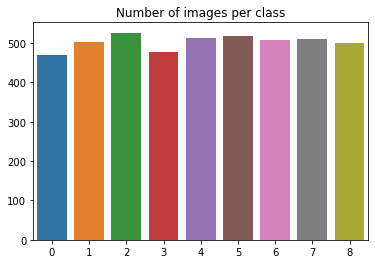

In [81]:
# Plotten der gezälten Bilder
sns.barplot(x=list(range(9)), y=class_count1)
plt.title('Number of images per class')

In den Trainingsdaten von Dataset 1 liegen je Klasse zwischen 470 und 526 Bilder vor.

### 3.2 Erzeugen von Dataset 2

Hier wird Dataset 2 erzeugt, welches aus den selbst erzeugten Bidler aus Notebook 1 besteht und mit Bilder Datasets aus dem Internet angereichert wurde (https://images.cv/).  
Dataset 2 wird auf die gleiche Weise erzeugt wie Dataset 1, siehe Abschnitt 3.1.

In [291]:
# Aufruf der Funktion zum erstellen der Datasets Test und Validation
image_size2 = [128, 128]
batch_size2 = 32
train_ds2, val_ds2 = create_datasets(image_size2, batch_size2, r"C:\Users\olive\Documents\HdM\3. Semester\Machine Learning\Project Whale\Bilder2")

Found 14500 files belonging to 9 classes.
Using 10150 files for training.
Found 14500 files belonging to 9 classes.
Using 4350 files for validation.


In [292]:
test_ds2 = val_ds2.take(68)
val_ds2 = val_ds2.skip(68)

print('Batches for testing -->', test_ds2.cardinality())
print('Batches for validating -->', val_ds2.cardinality())

Batches for testing --> tf.Tensor(68, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(68, shape=(), dtype=int64)


In [293]:
y_train_class2 = list()
for images, labels in train_ds2:
    for i, label in enumerate(labels):
        y_train_class2.append(np.argmax(label, axis=None, out=None))

In [241]:
class_count2 = list()
for c in range(len(class_names)):
    class_count2.append(y_train_class2.count(c))
 
print(class_count2)

[737, 784, 1080, 1295, 1293, 1129, 933, 1490, 1409]


Text(0.5, 1.0, 'Number of images per class')

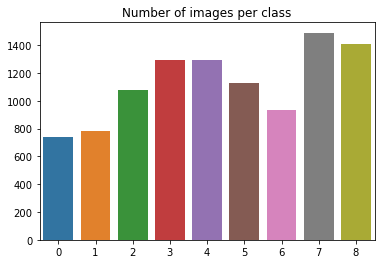

In [242]:
# Plotten der gezälten Bilder
sns.barplot(x=list(range(9)), y=class_count2)
plt.title('Number of images per class')

In den Trainingsdaten von Dataset 2 liegen mehr Bilder vor als in Dataset 1, da hier zusätzliche die Bilder von https://images.cv/ verwendet wurden. Auch die Anzahl der Bilder je Klasse weicht stärker voneinander ab.  
Klasse 0 (Chicken/Huhn) zum Beispiel ist nur mit 737 Bildern vertreten, während für Klasse 7 (Tit/Meise) 1409 Bilder vorliegen.  
Dabei besteht die Gefahr, dass Modelle auf Basis dieser Trainingsdaten biased gegenüber der stärker vertretenen Klassen sind oder schlechte Accuracy Werte für schwach vertretene Klassen in der gesamten Accuracy des Modells untergehen.  
Da später jedoch die Accuracy je Klasse getrackt werden soll und auch kein bias gegenüber stark vertretenen Klassen festgestellt werden konnte, sollen die Bilder alle als Traingsmaterial für das Modell behalten werden.

### 3.3 Erzeugen von Dataset 3

Hier wird Dataset 3 erzeugt, welches nur aus den Bilder Datasets aus dem Internet besteht (https://images.cv/).  
Dataset 3 wird auf die gleiche Weise erzeugt wie Dataset 1, siehe Abschnitt 3.1.

In [90]:
# Aufruf der Funktion zum erstellen der Datasets Test und Validation
image_size3 = [64, 64]
batch_size3 = 32
train_ds3, val_ds3 = create_datasets(image_size3, batch_size3, r"C:\Users\olive\Documents\HdM\3. Semester\Machine Learning\Project Whale\Bilder3")

Found 9682 files belonging to 9 classes.
Using 6778 files for training.
Found 9682 files belonging to 9 classes.
Using 2904 files for validation.


In [91]:
test_ds3 = val_ds3.take(46)
val_ds3 = val_ds3.skip(46)

print('Batches for testing -->', test_ds3.cardinality())
print('Batches for validating -->', val_ds3.cardinality())

Batches for testing --> tf.Tensor(46, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(45, shape=(), dtype=int64)


In [92]:
y_train_class3 = list()
for images, labels in train_ds3:
    for i, label in enumerate(labels):
        y_train_class3.append(np.argmax(label, axis=None, out=None))

In [93]:
class_count3 = list()
for c in range(len(class_names)):
    class_count3.append(y_train_class3.count(c))
 
print(class_count3)

[804, 740, 535, 748, 696, 603, 810, 926, 916]


Text(0.5, 1.0, 'Number of images per class')

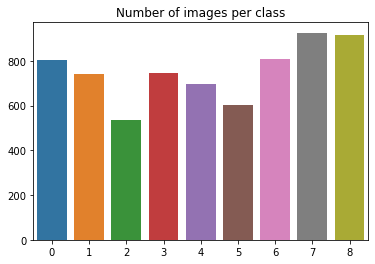

In [94]:
# Plotten der gezälten Bilder
sns.barplot(x=list(range(9)), y=class_count3)
plt.title('Number of images per class')

Ähnlich wie bei Dataset 2 sind hier unterschiedlich viele Bilder je Label enthalten. Aus den selben Gründen wie bei Dataset 2 sollen die Bilder so behalten werden.

# 4. Bilderexploration

In diesem Kapitel geht es darum, ein Gefühl für die Daten zu bekommen, indem Bilder der verschiedenen Klassen visualisiert werden.  

Hierfür wollen wir mit dem folgenden Code zunächst ein Bild jeder Klasse mit dem dazugehörigen Label anzeigen. Dafür wird in einer Schleife durch die ersten zwei Batches des Datasets iteriert und ein Bild geplotted, sofern nicht bereits in einer vorherigen Iteration bereits ein Bild dieser Klasse geplotted wird. Dies realisieren wir mit der liste *plotted*. Wird ein Bild einer Klasse geplotted, wird am enstprechenden Index der Klassennummer der Wert von *plotted* auf 'plotted' gesetzt. Bevor ein Bild geplotted wird, wird in einer if-Bedingung geprüft, ob diese Klasse bereits geplotted wurde. Falls nicht, wird das Bild geplotted und anschließend *plotted* upgedated, falls ja wird mit dem nächsten Element weitergemacht.

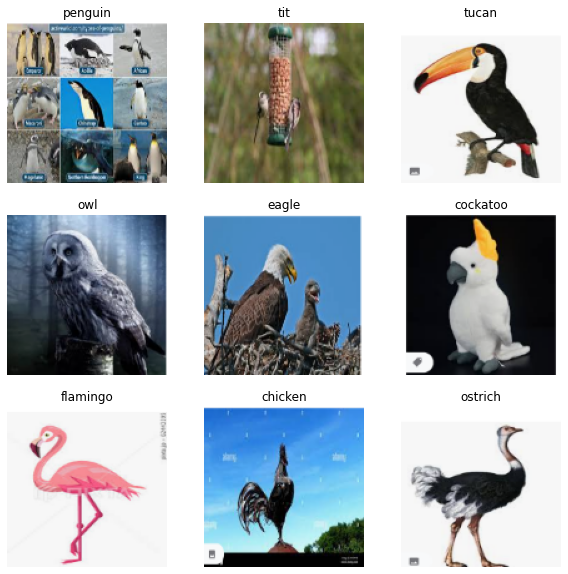

In [24]:
plt.figure(figsize=(10, 10))
pos=0
plotted = list(range(10))
for images, labels in train_ds1.take(2):
    for i in range(batch_size1):
        if(plotted[np.argmax(labels[i], axis=None, out=None)] != 'plotted'):
            ax = plt.subplot(3, 3, pos + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
            plt.axis("off")
            plotted[np.argmax(labels[i], axis=None, out=None)] = 'plotted'
            pos=pos+1        
        else:
            continue

Die oben beschriebene Visualisierung eines Bilds jeder Klasse wird für das dataset 2 wiederholt.

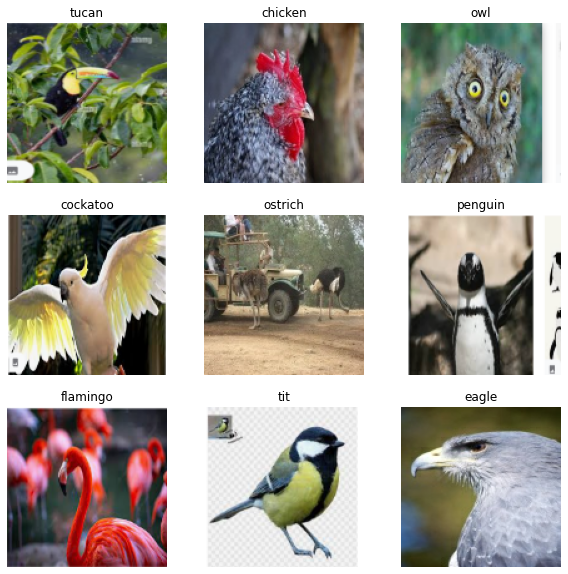

In [25]:
plt.figure(figsize=(10, 10))
pos=0
plotted = list(range(10))
for images, labels in train_ds2.take(2):
    for i in range(batch_size3):
        if(plotted[np.argmax(labels[i], axis=None, out=None)] != 'plotted'):
            ax = plt.subplot(3, 3, pos + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
            plt.axis("off")
            plotted[np.argmax(labels[i], axis=None, out=None)] = 'plotted'
            pos=pos+1        
        else:
            continue

In beiden Plots ist zu erkennen, dass es deutliche Unterschiede der Klassenmerkmale gibt. Die Interclass Differenz, also die Unterschiede in Merkmalen verschiedener Klassen, ist dementsprechend ausreichend vorhanden. Beispielsweise sind Tucans deutlich an ihrem großen, bunten Schnabel zu erkennen, während Cockatoos einen auffälligen Federschmuck am Kopf besitzen.  
Ein Unterschied zwischen den beiden Datasets ist zunächst nicht zu erkennen.

In [26]:
print(list(train_ds1.as_numpy_iterator()))

[(array([[[[246.8895  , 246.8895  , 246.8895  ],
         [244.80417 , 244.80417 , 244.80417 ],
         [244.      , 244.      , 244.      ],
         ...,
         [234.17969 , 235.78125 , 238.1836  ],
         [234.17969 , 235.78125 , 238.1836  ],
         [234.17969 , 235.78125 , 238.1836  ]],

        [[246.17917 , 246.17917 , 246.17917 ],
         [245.53204 , 245.53204 , 245.53204 ],
         [245.19531 , 245.19531 , 245.19531 ],
         ...,
         [255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ]],

        [[245.44748 , 245.44748 , 245.44748 ],
         [245.66406 , 245.66406 , 245.66406 ],
         [246.      , 246.      , 246.      ],
         ...,
         [255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ],
         [255.      , 255.      , 255.      ]],

        ...,

        [[194.20935 , 194.20935 , 194.20935 ],
         [246.32935 , 246.32935 , 246.32935

Beim genaueren Untersuchen fällt auch auf, dass die in Notebook 1 erzeigten Bilder unterschiedliche Formate besitzen. Im Gegensatz zu den quadratischen Bildern aus den Datensets von https://images.cv/ tauchen hier Bilder in Hochformat und Querformat auf: Wo hast du das jetzt erkannt?? mit dem as_numpy_iterator?? oder für was ist der gut??

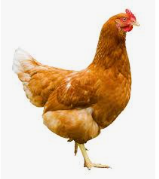

In [27]:
# Laden eines selbst erzeugten Bildes mit Hochformat
tf.keras.utils.load_img(r"C:\Users\olive\Documents\HdM\3. Semester\Machine Learning\Project Whale\Bilder1\chicken\chicken (48).png")

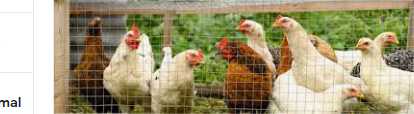

In [28]:
# Laden eines selbst erzeugten Bildes mit Querformat
tf.keras.utils.load_img(r"C:\Users\olive\Documents\HdM\3. Semester\Machine Learning\Project Whale\Bilder1\chicken\chicken (51).png")

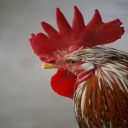

In [29]:
# Laden eines Bilds von https://images.cv/ in qudratischem Format
tf.keras.utils.load_img(r"C:\Users\olive\Documents\HdM\3. Semester\Machine Learning\Project Whale\Bilder3\chicken\0K3D5SDTO0RJ.jpg")

Die verschiedenen Formate der Bilder könnten für das Model später ein Problem darstellen und ggfs. Einfluss auf die Performance haben. Dies gilt es später zu beachten bzw. zu untersuchen.

Im folgenden Plot sollen 9 Bilder einer Klasse visualisiert werden. Dafür wird in der Variablen *plot_class* zunächst die ausgewählte Klasse und in *class_index* deren Index definiert.  
Anschließend iterieren wir wieder durch das Dataset (erste 10 Batches sollten) und plotten ein Bild nur, wenn ihr Label der zuvor definierten Klasse entspricht.

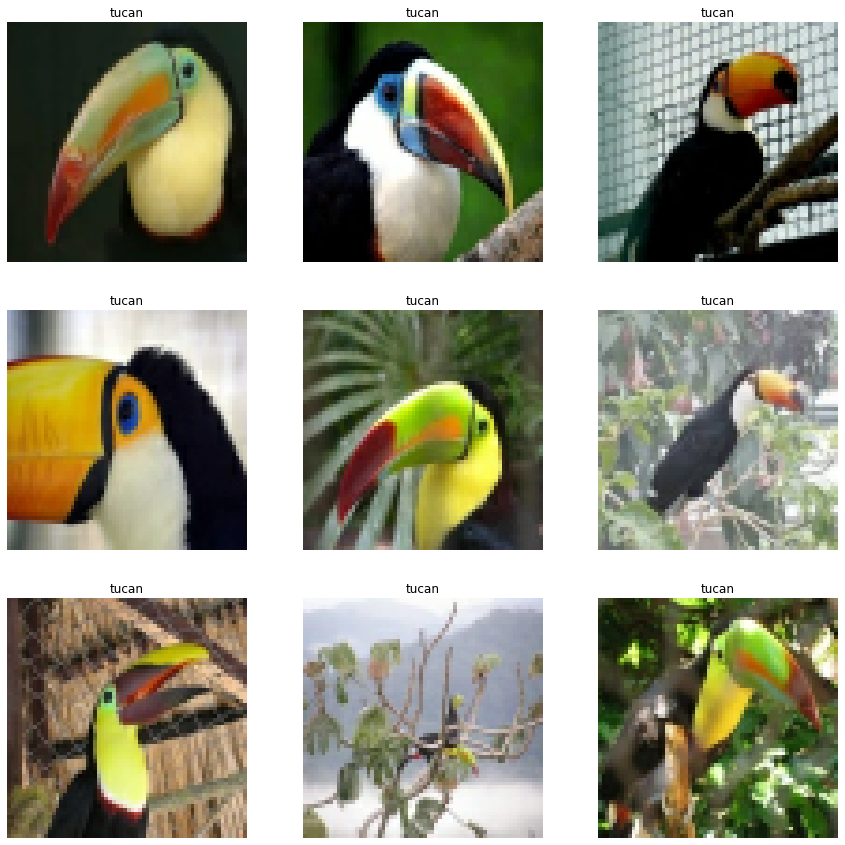

In [200]:
plot_class = "tucan"
class_index = class_names.index(plot_class)

plt.figure(figsize=(15, 15))
pos=0
for images, labels in train_ds3.take(10):
    for i in range(9):
      if(pos<9):
        if(np.argmax(labels[i], axis=None, out=None) == class_index):
            ax = plt.subplot(3, 3, pos + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(plot_class)
            plt.axis("off")
            pos=pos+1        
        else:
            continue
      else:
        break

Die Bilder zeigen den Tucan immer aus anderen Winkeln oder Positionen. Allerdings sind dessen Hauptmerkmale (großer, bunter Schnabel, gelbe Brust, sonst hauptsächliches schwarzes Gefieder) in allen Bildern ausreichend vorhanden. Die Intraclass Differenz, also die Unterschiede innerhalb einer Klasse, sind daher eher klein.  
  

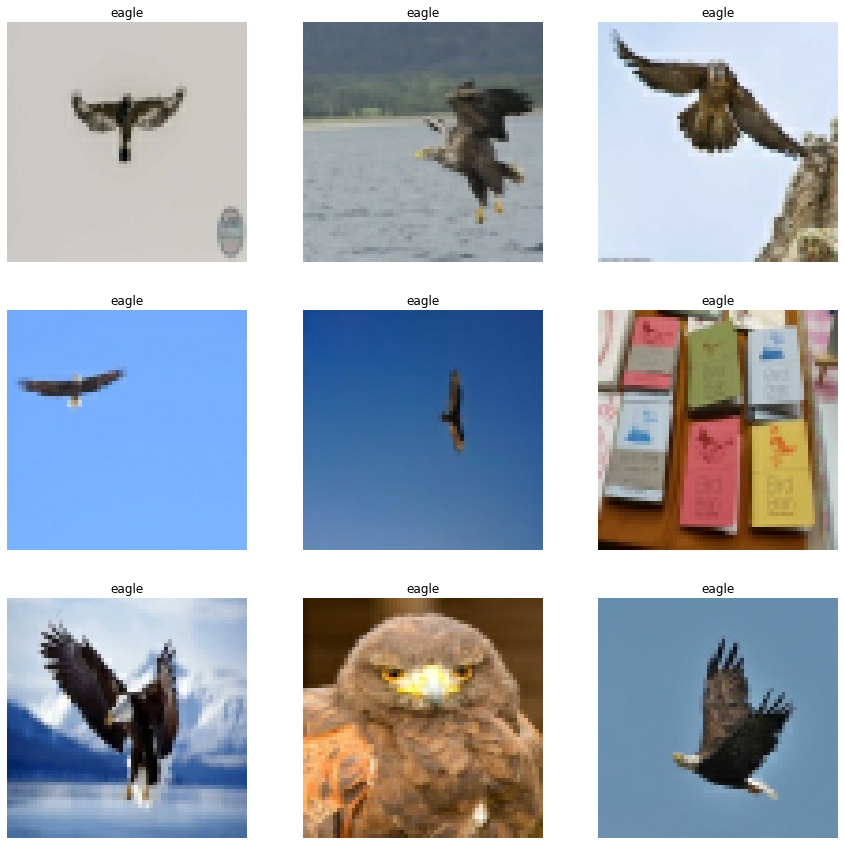

In [245]:
plot_class = "eagle"
class_index = class_names.index(plot_class)

plt.figure(figsize=(15, 15))
pos=0
for images, labels in train_ds3.take(20):
    for i in range(9):
      if(pos<9):
        if(np.argmax(labels[i], axis=None, out=None) == class_index):
            ax = plt.subplot(3, 3, pos + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(plot_class)
            plt.axis("off")
            pos=pos+1        
        else:
            continue
      else:
        break

Die Bilder von Adlern unterscheiden sich schon etwas mehr, als die der Tucans. Die Adler werden in verschiednen Flugplositionen gezeigt. Allerdings sind auch hier große Ähnlichkeiten festzustellen, wie beispielsweise die großen, ausgebreiteten Flügen und der helle Kopf. Somit ist die Intraclass Differenz immer noch relativ gering.


Durch die Datenexploration konnten wir somit feststellen, dass die Intraclass Differenz eher gering ist, während eine ausreichende Interclass Differenz vorhanden ist. Die Datenset scheint also geeignet, um eine Bildklassifikation mit Neuronalen Netzen durchzuführen und dabei auch gute Ergebnisse zu erzielen.

# 5. Image Augmentation

Um mit einer Bildklassifikation mithilfe von Neuronalen Netzen gute Ergebnisse zu erzielen, ist eine große Menge an Trainingsdaten notwendig. Nur so kann das Modell ausreichend trainiert werden, um die Merkmale unterschiedlicher Klassen zu gut zu unterscheiden.  
Liegen nicht genügend Trainingsdaten vor, kann durch Image Augmentation die Datenmenge künstlich vergrößert werden.  
Dafür werden vorhandene Bilder zufällig gedreht, gespiegelt und vergrößert bzw. verkleinert und diese neu generierten Bilder dem Modell als neue Bilder zur Verfügung zu stellen.

Keras stellt hierfür verschiedene Funktionen zur Verfügung. Mit *RandomFlip* wird ein Bild zufällig (auswählbar ob horizontal, vertikal oder beides) gespiegelt, während *RandomRotation* ein Bild um einen gewissen Faktor zufällig dreht. Zusätzlich existiert beispielsweise auch der Layer *RandomZoom*, unter dessen Verwendung ein Bild zufällig vergrößert wird.  

Nachfolgend demonstrieren wir die Methoden *RandomFlip* und *RandomRotation* mit unserem Datenset.  
Hierfür können die beiden Preprocessing Layer in einem Sequential Objekt kombiniert werden, sodass diese sich wie eine Funktion mit dem Namen *data_augmentation* aufrufen lassen. 

In [31]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
    ]
)

Das Ergebnis dieser Augmentation visualisieren wir wieder in einem Plot, indem wir durch das Datenset iterieren und zunächst das Originalbild und anschließend das augmentierte Bild anzeigen. Die Augmentation erfolgt, indem die Originalbilder *images* an die eben erzeugte Funktionalität *data_augmentation* übergeben werden. Dadurch wird jedes Originalbild einmal indivduell zufällig gespiegelt und rotiert.

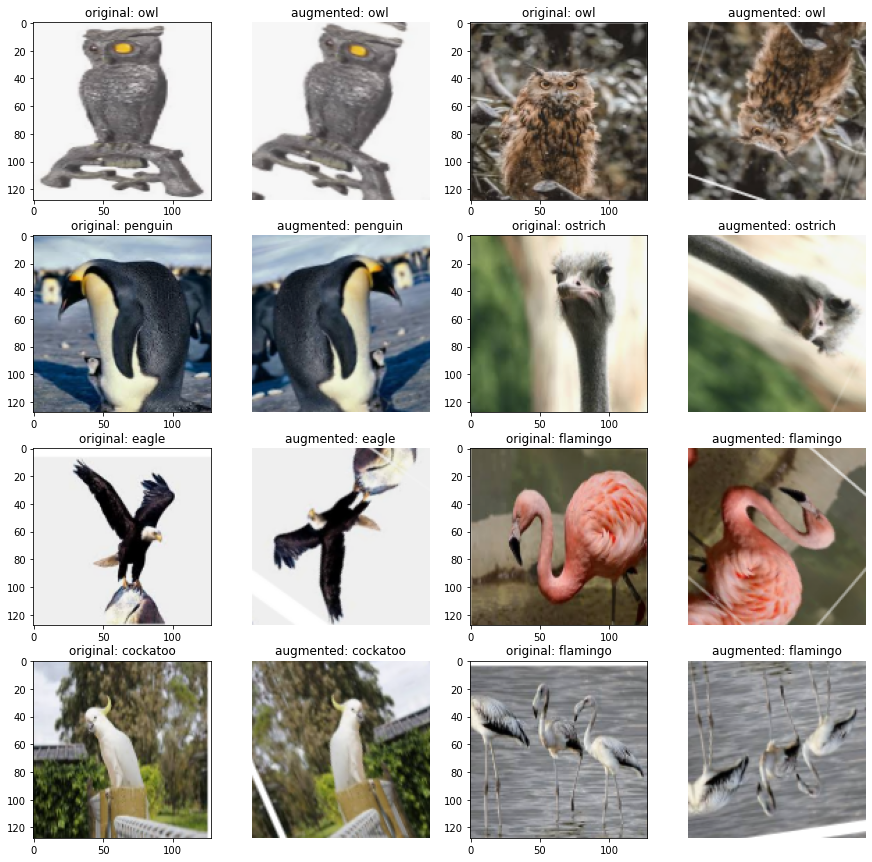

In [32]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds1.take(1):
    augmented_images = data_augmentation(images)
    for i in range(0, 15, 2):
        axarr = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("original: " + class_names[np.argmax(labels[i], axis=None, out=None)])
        axarr = plt.subplot(4, 4, i + 2)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title("augmented: " + class_names[np.argmax(labels[i], axis=None, out=None)])
        plt.axis("off")




Es ist zu erkennen, dass jedes Orignalbild mit einem anderen Faktor gedreht wurde und auch jedes Originalbild anders gespiegelt wurde.

Die Image Augmentation kann entweder zu Beginn auf das Datenset angewandt werden und deren Ergebnisse persistiert und dem Datenset hinzugefügt werden. Somit vergrößert sich natürlich die Datenmenge. In einer Trainingsepoche des Neuronalen Netzes stehen mehr Bilder zur Verfügung, als wenn nur Originalbilder verwendet werden.    
Alternativ besteht die Möglichkeit, die eben demonstrierten Preprocessing Layer der Architektur eines Neuronalen Netzes hinzuzufügen. Somit wird in der Trainingsphase jedes Bild zunächst augmentiert, bevor es den Rest des Modells durchläuft. Dadurch vergrößert sich zwar nicht die Datenmenge innerhalb einer Modellepoche, da jedes Bild genau einmal das neuronale Netz durchläuft. In der nächsten Epoche wird das Bild aber wieder augmentiert, vermutlich um einen anderen Faktor als in der vorherigen Epoche. Somit erscheint es für das Modell als neues Bild.  
Vergrößern wir also die Anzahl der Epochen, im Vergleich zu Alternative 1, so erzielen wir auf lange Sicht den gleichen Effekt und vergrößern unser Datenset. Für diese Alternative haben wir uns in unserem Projekt entschieden, weshalb die Ergebnisse der demonstrierten Image Augmentation nicht gespeichert werden. Stattdessen fügen wir die beiden Preprocessing Layer *RandomFlip* und *RandomRotation* unserer Modelle hinzu.

# 6. Building & Training a CNN Model from Scratch

Da sich wie bereits erwähnt CNN am besten zur Multiclass Classification von Bildern eignen, sollen in diesem Kapitel verschiedene CNN Architekturen selbst erstellt und getestet werden. Durch das Designen einer geeigneten Architektur sowie das Auswählen optimaler Parameter soll eine möglichst hohe Accuracy erzielt werden.  
Wir beginnen mit einem simplen Modell und steigern die Komplexität der Architektur & Parameter von Modell zu Modell.

## 6.1 Model 1 - simples CNN

### a) Model 1 - Introduction

In diesem ersten Versuch soll ein simples CNN mit wenigen Layern und wenigen Filtern erstellt werden. Dies soll als Test dienen, welche Ergebnisse mit einem einfachen Netz und wenig Ressourcen erzielt werden können.  
Hier soll der Fokus noch nicht auf der Optimierung der Architektur und der Hyperparameter liegen. Dies erfolgt später in Netzen mit Komplexerer Architektur, welche auch mehr Aussicht auf Erfolg bieten.  
Außerdem bietet sich dieses Netz an, die drei unterschiedlichen datasets durchzutesten und zu vergleichen, da das CNN auf Grund der einfachen Architektur vergleichsweise schnell trainiert werden kann.

### b) Model 1 - Construction

Um möglichst einfach mehrere gleiche Modelle zum Testen der verschiedenen Datasets erstellen zu können, wird die Konstruktion des Modells in eine Funktion ausgelagert, welche immer wieder aufgerufen werden kann um ein gleiches CNN zu erstellen.

In [99]:
def construct_model1():
    cnn1 = Sequential()
    cnn1.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(64, 64,3), padding='same',activation='relu'))
    cnn1.add(Dropout(0.2))
    cnn1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding='same'))
    cnn1.add(MaxPool2D(pool_size=(2, 2)))
    cnn1.add(Flatten())
    cnn1.add(Dense(512, activation='relu'))
    cnn1.add(Dropout(0.5))
    cnn1.add(Dense(len(class_names), activation='softmax'))
    return cnn1

**Architektur und Parameter:**  
An dieser Stelle wurde nicht viel Wert auf optimale Architektur oder Parameter gelegt. Layer, Filter und weitere Parameter wurden lediglich so gewählt, dass das Training des Modells einigermaßen schnell auf lokaler Hardware durchführbar ist um möglichst schnell ein erstes Gefühl für die Verwertbarkeit der verschiedenen Datasets zu bekommen sowie für den Accuracy Wert eines nicht optimierten, simplen CNN.  
Die Bilder zum Trainieren der Modelle wurden für diese Modelle mit einer Auflösung von 64x64 Pixel eingelesen, da nach Tests keine Auswirkung der Auflösung festgestellt werden konnte und mit 64x64 Pixel das Modell schneller trainiert werden kann auf Grund der geringeren Anzahl an trainierbaren Parametern.

Als nächstes werden nun drei Modelle erstellt, welche mit den drei unterschiedlichen datasets trainiert werden sollen, um Unterschiede zwischen den datasets zu untersuchen.  
Das erste Modell soll mit dataset1 trainiert werden, das zweite Modell mit dataset2 und das dritte Modell mit dataset3.  
Im nächsten Schritt wird die zuvor definierte Funktion drei Mal aufgerufen, um drei gleiche Modelle zu erstellen welche dann mit den drei unterschiedlichen datsets trainiert werden können.

In [100]:
# Erstellen des ersten simplen CNN Modells
model1_1=construct_model1()
model1_1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [111]:
# Erstellen des zweiten simplen CNN Modells
model1_2=construct_model1()
model1_2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [112]:
# Erstellen des dritten simplen CNN Modells
model1_3=construct_model1()
model1_3.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

Bevor die Modelle trainiert werden, können wir die Layer unserer simplen CNN Architektur mit Hilfe einer visualkeras util visualisieren:

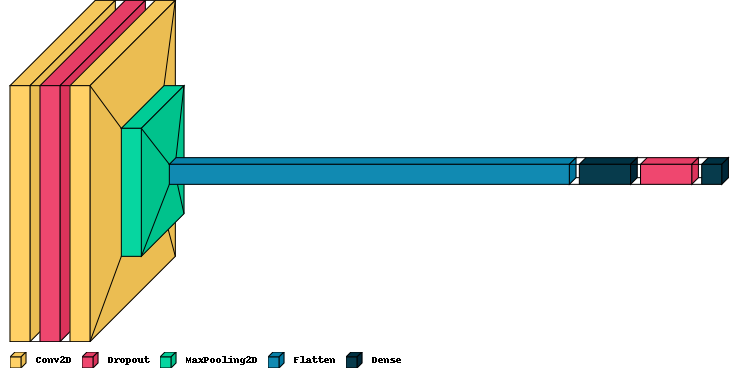

In [103]:
# Visuelle Darstellung der Layer, gleich für alle drei erstellten Modelle
visualkeras.layered_view(model1_1, legend=True)

In [109]:
model1_1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 dropout_14 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 32768)             0         
                                                                 
 dense_22 (Dense)            (None, 512)               16777728  
                                                     

### c) Model 1 - Training

Nun werden die zuvor erstellten Modelle mit den jeweiligen datasets trainiert.

In [104]:
# Trainieren des einfachen CNN mit dataset 1 (in Notebook 1 erzeugte Bilder)
print("Trainieren des einfachen CNN mit dataset 1 (in Notebook 1 erzeugte Bilder)")
history1_1 = model1_1.fit(train_ds1, batch_size=32, epochs=12, verbose=True, validation_data=val_ds1)

Trainieren des einfachen CNN mit dataset 1 (in Notebook 1 erzeugte Bilder)
Epoch 1/12
142/142 [==============================] - 26s 179ms/step - loss: 111.1921 - accuracy: 0.1181 - val_loss: 2.1943 - val_accuracy: 0.1249
Epoch 2/12
142/142 [==============================] - 26s 183ms/step - loss: 2.1762 - accuracy: 0.1423 - val_loss: 2.2005 - val_accuracy: 0.1196
Epoch 3/12
142/142 [==============================] - 26s 182ms/step - loss: 2.0975 - accuracy: 0.2049 - val_loss: 2.2505 - val_accuracy: 0.1534
Epoch 4/12
142/142 [==============================] - 26s 185ms/step - loss: 1.9762 - accuracy: 0.2664 - val_loss: 2.3837 - val_accuracy: 0.1672
Epoch 5/12
142/142 [==============================] - 26s 182ms/step - loss: 1.8399 - accuracy: 0.3239 - val_loss: 2.5809 - val_accuracy: 0.1799
Epoch 6/12
142/142 [==============================] - 25s 176ms/step - loss: 1.7185 - accuracy: 0.3743 - val_loss: 2.7120 - val_accuracy: 0.1746
Epoch 7/12
142/142 [==============================] -

In [113]:
# Trainieren des einfachen CNN mit dataset 2 (in Notebook 1 erzeugte Bilder + Bilder von https://images.cv/)
print("Trainieren des einfachen CNN mit dataset 2 (in Notebook 1 erzeugte Bilder + Bilder von https://images.cv/)")
history1_2 = model1_2.fit(train_ds2, batch_size=32, epochs=12, verbose=True, validation_data=val_ds2)

Trainieren des einfachen CNN mit dataset 2 (in Notebook 1 erzeugte Bilder + Bilder von https://images.cv/)
Epoch 1/12
318/318 [==============================] - 57s 179ms/step - loss: 25.5834 - accuracy: 0.1824 - val_loss: 2.1637 - val_accuracy: 0.1812
Epoch 2/12
318/318 [==============================] - 57s 178ms/step - loss: 2.0812 - accuracy: 0.2289 - val_loss: 2.1538 - val_accuracy: 0.1780
Epoch 3/12
318/318 [==============================] - 57s 178ms/step - loss: 1.9549 - accuracy: 0.2826 - val_loss: 2.2053 - val_accuracy: 0.2194
Epoch 4/12
318/318 [==============================] - 57s 178ms/step - loss: 1.8038 - accuracy: 0.3486 - val_loss: 2.3822 - val_accuracy: 0.2222
Epoch 5/12
318/318 [==============================] - 57s 179ms/step - loss: 1.6596 - accuracy: 0.4078 - val_loss: 2.4791 - val_accuracy: 0.2282
Epoch 6/12
318/318 [==============================] - 57s 179ms/step - loss: 1.4568 - accuracy: 0.4792 - val_loss: 2.4967 - val_accuracy: 0.2534
Epoch 7/12
318/318 [==

In [114]:
# Trainieren des einfachen CNN mit dataset 3 (nur Bilder von https://images.cv/)
print("Trainieren des einfachen CNN mit dataset 3 (nur Bilder von https://images.cv/)")
history1_3 = model1_3.fit(train_ds3, batch_size=32, epochs=12, verbose=True, validation_data=val_ds3)

Trainieren des einfachen CNN mit dataset 3 (nur Bilder von https://images.cv/)
Epoch 1/12
212/212 [==============================] - 43s 199ms/step - loss: 87.1206 - accuracy: 0.1785 - val_loss: 2.1573 - val_accuracy: 0.1913
Epoch 2/12
212/212 [==============================] - 41s 192ms/step - loss: 2.0826 - accuracy: 0.2316 - val_loss: 2.1355 - val_accuracy: 0.2004
Epoch 3/12
212/212 [==============================] - 41s 193ms/step - loss: 1.9609 - accuracy: 0.2868 - val_loss: 2.1087 - val_accuracy: 0.2207
Epoch 4/12
212/212 [==============================] - 42s 197ms/step - loss: 1.8132 - accuracy: 0.3464 - val_loss: 2.1459 - val_accuracy: 0.2605
Epoch 5/12
212/212 [==============================] - 42s 199ms/step - loss: 1.6763 - accuracy: 0.3944 - val_loss: 2.1253 - val_accuracy: 0.2919
Epoch 6/12
212/212 [==============================] - 42s 199ms/step - loss: 1.5111 - accuracy: 0.4717 - val_loss: 2.3439 - val_accuracy: 0.2926
Epoch 7/12
212/212 [==============================

### d) Model 1 Evaluation

Für die Evaluation der Modelle ist zunächst deren Trainings- und Validationaccuracy sowie der Loss interessant.  
Hierfür wird die Funktion *plot_accuracy* definiert, welche den Verlauf dieser beiden Werte für Trainings- und Validationdaten über alle Epochen visualisiert. Als Input benötigt diese Funktion die Modelhistory, welche in der Trainingsphase des jeweiligen Modells erstellt wurde. Aus dieser Historie können die einzelnen Epochen Werte von Accuracy und Loss sowie deren Maximum bzw. Minimum bestimmt und anschließend geplotted werden.

In [115]:
# Erstellen einer Funktion zum plotten der Accuracy
def plot_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    max_val_acc=np.max(val_acc)

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    min_val_loss=np.min(val_loss)

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(16,8))
    ax = plt.subplot(1, 2, 1)
    plt.grid(True)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    print("Maximum accuracy: ",max_val_acc)
    print("Minimum Loss: ",min_val_loss)



    ax = plt.subplot(1, 2, 2)
    plt.grid(True)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Accuracy und Loss des simplen CNN mit dataset 1:
Maximum accuracy:  0.2359788417816162
Minimum Loss:  2.1943488121032715


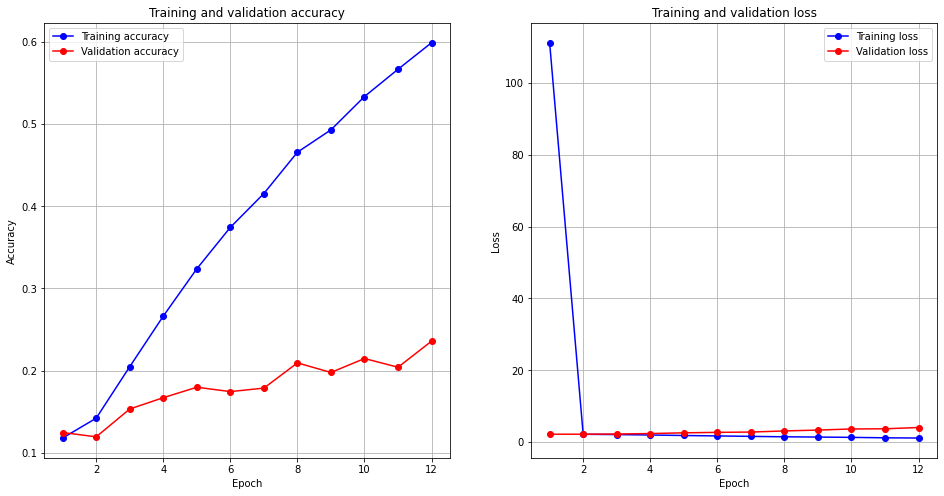

Accuracy und Loss des simplen CNN mit dataset 2:
Maximum accuracy:  0.38178473711013794
Minimum Loss:  2.1537678241729736


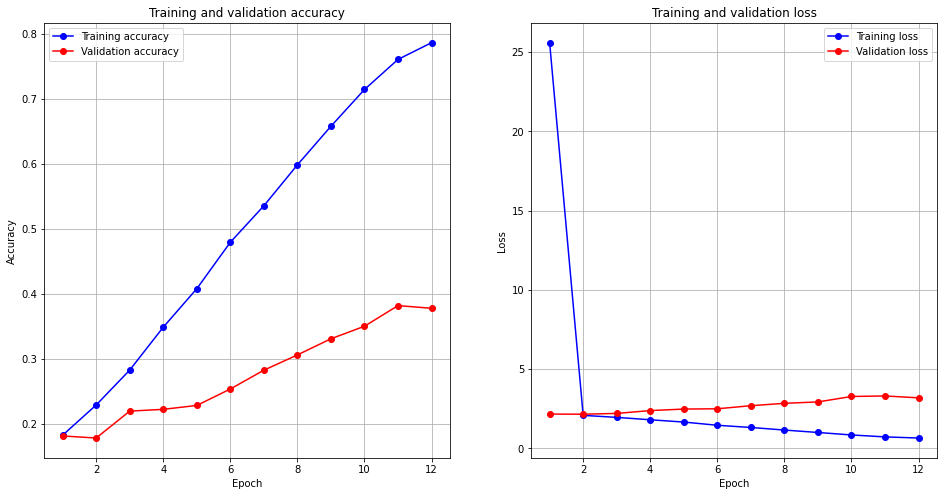

Accuracy und Loss des simplen CNN mit dataset 3:
Maximum accuracy:  0.3819832503795624
Minimum Loss:  2.1086957454681396


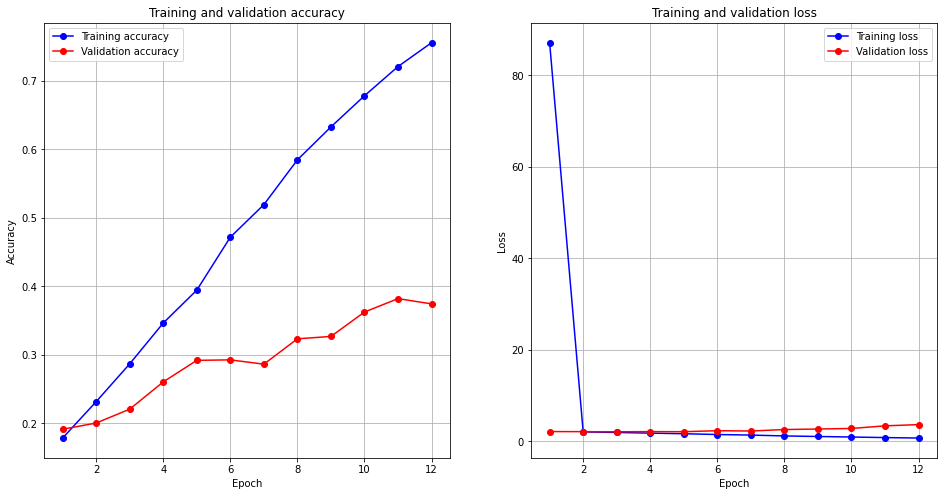

In [116]:
print("Accuracy und Loss des simplen CNN mit dataset 1:")
plot_accuracy(history1_1)

print("Accuracy und Loss des simplen CNN mit dataset 2:")
plot_accuracy(history1_2)

print("Accuracy und Loss des simplen CNN mit dataset 3:")
plot_accuracy(history1_3)

Mit Accuracy und Loss alleine kann, wie zu Beginn des Notebooks beschrieben, keine ausreichende Aussage über Performance eines Modells getroffen werden. Daher wollen wir nun auch Precision, Recall und F1-Score der Modelle betrachten.  
Hierfür definieren wir zunächst die Funktion *predict_testdata*, die für das übergebene Modell und Testdaten y_true und y_pred bestimmt. Dafür iteriert die Funktion über die Testdaten und bestimmt für jeden Batch die jeweils richtige und die druch das Modell vorhergesagte Klasse. Zuletzt werden die einzelnen Batchelemente von y_true und y_pred in jeweils ein Tensorobjekt konvertiert und dieses als Output der Funktion zurückgegeben.

In [117]:
#Funktion berechnet y_pred und y_true für ein Modell, daher Modell und richtiges test_ds mitgeben, als output kommt y_true und y_pred
def predict_testdata(model, test_ds):
    
   y_pred = []  # store predicted labels
   y_true = []  # store true labels

   # iterate over the dataset
   for image_batch, label_batch in test_ds:   
      # append true labels
      y_true.append(np.argmax(label_batch, axis=-1))
      # compute predictions
      preds = model.predict(image_batch)
      # append predicted labels
      y_pred.append(np.argmax(preds, axis = - 1))

   # convert the true and predicted labels into tensors
   correct_labels = tf.concat([item for item in y_true], axis = 0)
   predicted_labels = tf.concat([item for item in y_pred], axis = 0)

   return correct_labels, predicted_labels

Diese Funktion wird nun beispielhaft für das beste der oben trainierten Modelle (model1_3) und test_ds3 aufgerufen und die beiden Ergebnisse in den Variablen model1_3_corL (für correctLabel) und model1_3_predL (für predictedLabel) gespeichert.

In [118]:
#Aufruf der Funktion
model1_3_corL, model1_3_predL = predict_testdata(model1_3, test_ds3)

1/1 [==============================] - 0s 43ms/step


Mithilfe der eben erzeugten Variablen können die Metriken Precision, Recall und F1-Score nun für das Modell angezeigt werden.

In [119]:
print(classification_report(model1_3_corL, model1_3_predL,target_names = class_names))

              precision    recall  f1-score   support

     chicken       0.35      0.35      0.35       180
    cockatoo       0.31      0.30      0.30       138
       eagle       0.40      0.31      0.35       129
    flamingo       0.37      0.42      0.40       160
     ostrich       0.37      0.16      0.23       165
         owl       0.19      0.20      0.19       121
     penguin       0.30      0.41      0.35       192
         tit       0.43      0.40      0.41       197
       tucan       0.39      0.47      0.43       190

    accuracy                           0.35      1472
   macro avg       0.34      0.34      0.33      1472
weighted avg       0.35      0.35      0.34      1472



Anschließend wird die Confusion Matrix des Modells mithilfe der importieren Funktion *plot_confusion_matrix* erstellt.

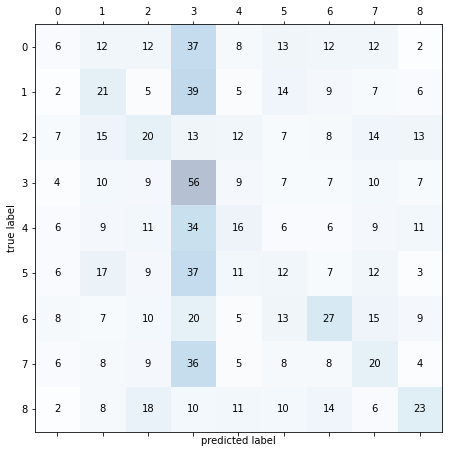

In [120]:
plot_confusion_matrix(confusion_matrix(model1_3_corL, model1_3_predL))

### e) Model 1 - Fazit

In Modell 1 können wir bereits erkennen, dass sich Dataset 1 nicht besonders gut eignet. Daher sollen in den weiteren Modellen nurnoch Dataset 2 und Dataset 3 verwendet werden. Die Performance von Modell 1 ist noch nicht optimal, der Fokus auf Optimierung der Architektur und Parameter erfolgt allerdings auch erst in Modell 2.

## 6.2 Model 2 - komplexeres CNN

### a) Model 2 - Introduction

Mit den bei Modell 1 gewonnen Erkentnissen soll nun ein zweites Modell designed werden, welches mehr Layer und Filter besitzt als das vorherige und damit auch mehr trainierbare Parameter. Der Anspruch ist es, hierbei eine Konfiguration zu finden, welche sich in angemessener Zeit auf der lokalen Hardware trainieren lässt.

### b) Model 2 - Construction

In [231]:
def construct_cnn2(learningRate):
    cnn2 = Sequential()
    cnn2.add(RandomFlip("horizontal_and_vertical", input_shape=(64, 64,3)))
    cnn2.add(RandomRotation(0.2))
    cnn2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    cnn2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    cnn2.add(MaxPool2D((2, 2)))
    cnn2.add(Dropout(0.2))
    cnn2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    cnn2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    cnn2.add(MaxPool2D((2, 2)))
    cnn2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    cnn2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    cnn2.add(MaxPool2D((2, 2)))
    cnn2.add(Flatten())
    cnn2.add(Dense(256, activation='relu'))
    cnn2.add(Dense(256, activation='relu'))
    cnn2.add(Dropout(0.2))
    cnn2.add(Dense(len(class_names), activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(lr=learningRate)
    cnn2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return cnn2

**Architektur und Parameter:**  
**Batch Size:** 32 hat sich durch Tests als effizient erwiesen  
**Auflösung der Bilder**: 32x32 Pixel erzielte weniger gute Ergebnisse, zwischen 64x64 und 128x128 konnten in mehreren Probedurchläufen keine ausschlaggebenden Unterschiede festegestellt werden. Aus Performance Gründen wurde daher 64x64 Pixel gewählt.  
**Anzahl Layer:**  Bei der Anzahl an Layer wurde durch Tests versucht, ein Optimum zwischen Geschwindigkeit und Ergebnis zu finden. Zur Orientierung für den Aufbau der Layer wurden best practice Architekturen aus dem Internet, bspw. GitHub herangezogen.  
**Anzahl Filter:** Hier wurde als best practice eine von Layer zu Layer aufsteigende Anzahl an Filtern getestet zwischen 32 und 256. Die beste Ergebnisse wurden wie oben dargestellt erzielt.  
**Filtergröße:** 3x3 als Standard bei Bildern kleiner 128x128  
**Dropout:**  
**Augmentation:**  Mit den Keras Layern Random Flip und Random Rotation konnten etwas bessere Ergebnisse erzielt werden.  
**Activation:** Als Aktivierungsfunktion für die Hidden Layer wurden relu und tanh als CNN Standards getestet, mit relu konnten die besseren Ergebnisse erzielt werden. Für den Ausgabe Layer wurde softmax als Standard gewählt.  
**Optimizer:**  Adam und SGD wurden getestet, wobei keine merkbaren Unterschiede aufgefallen sind, daher wurde Adam gewählt.  
**Learning Rate:** Learning Rate von 0,001 bewährt, liefert ein "stabileres" Training mit weniger Schwankungen in Validation Accuracy als bspw. 0,01  
**Loss:** Categorical Crossentropy als Standard für multiclass classification CNN.


In [243]:
Model2_1=construct_cnn2(0.001)
Model2_1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [233]:
Model2_2=construct_cnn2(0.001)
Model2_2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

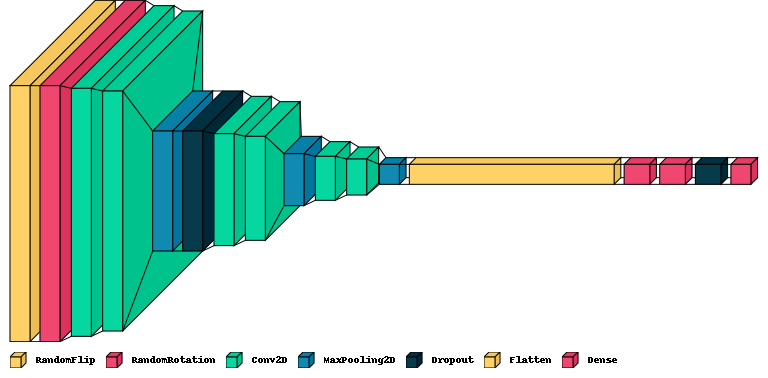

In [234]:
visualkeras.layered_view(Model2_1, legend=True)

In [235]:
Model2_1.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_21 (RandomFlip)  (None, 64, 64, 3)        0         
                                                                 
 random_rotation_18 (RandomR  (None, 64, 64, 3)        0         
 otation)                                                        
                                                                 
 conv2d_140 (Conv2D)         (None, 62, 62, 32)        896       
                                                                 
 conv2d_141 (Conv2D)         (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 dropout_56 (Dropout)        (None, 30, 30, 32)      

### c) Model 2 - Training

In [244]:
history2_1 = Model2_1.fit(train_ds2, batch_size=32, epochs=40, verbose=True, validation_data=val_ds2)

Epoch 1/40
318/318 [==============================] - 97s 296ms/step - loss: 2.0339 - accuracy: 0.2703 - val_loss: 1.9027 - val_accuracy: 0.2544
Epoch 2/40
318/318 [==============================] - 96s 301ms/step - loss: 1.6936 - accuracy: 0.3911 - val_loss: 1.8186 - val_accuracy: 0.3523
Epoch 3/40
318/318 [==============================] - 98s 307ms/step - loss: 1.5605 - accuracy: 0.4552 - val_loss: 1.7705 - val_accuracy: 0.3625
Epoch 4/40
318/318 [==============================] - 97s 306ms/step - loss: 1.4695 - accuracy: 0.4881 - val_loss: 1.7026 - val_accuracy: 0.3914
Epoch 5/40
318/318 [==============================] - 98s 308ms/step - loss: 1.3815 - accuracy: 0.5234 - val_loss: 1.6877 - val_accuracy: 0.3933
Epoch 6/40
318/318 [==============================] - 98s 307ms/step - loss: 1.3074 - accuracy: 0.5523 - val_loss: 1.6292 - val_accuracy: 0.4416
Epoch 7/40
318/318 [==============================] - 97s 306ms/step - loss: 1.2628 - accuracy: 0.5718 - val_loss: 1.7123 - val_ac

In [236]:
history2_2 = Model2_2.fit(train_ds3, batch_size=32, epochs=40, verbose=True, validation_data=val_ds3)

Epoch 1/40
212/212 [==============================] - 51s 233ms/step - loss: 2.1424 - accuracy: 0.2386 - val_loss: 1.7322 - val_accuracy: 0.3506
Epoch 2/40
212/212 [==============================] - 48s 228ms/step - loss: 1.7698 - accuracy: 0.3626 - val_loss: 1.6181 - val_accuracy: 0.4190
Epoch 3/40
212/212 [==============================] - 49s 230ms/step - loss: 1.6044 - accuracy: 0.4318 - val_loss: 1.4767 - val_accuracy: 0.4944
Epoch 4/40
212/212 [==============================] - 49s 230ms/step - loss: 1.5372 - accuracy: 0.4611 - val_loss: 1.4454 - val_accuracy: 0.4965
Epoch 5/40
212/212 [==============================] - 49s 230ms/step - loss: 1.4385 - accuracy: 0.4994 - val_loss: 1.3235 - val_accuracy: 0.5230
Epoch 6/40
212/212 [==============================] - 49s 231ms/step - loss: 1.3988 - accuracy: 0.5086 - val_loss: 1.3845 - val_accuracy: 0.5321
Epoch 7/40
212/212 [==============================] - 49s 229ms/step - loss: 1.3275 - accuracy: 0.5490 - val_loss: 1.1993 - val_ac

In [56]:
# Speichern des Models
#Model2_2.save('CNN2best.h5')

In [65]:
cnn2=load_model('CNN2best.h5')

In [66]:
cnn2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_11 (RandomFlip)  (None, 64, 64, 3)        0         
                                                                 
 random_rotation_8 (RandomRo  (None, 64, 64, 3)        0         
 tation)                                                         
                                                                 
 conv2d_53 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 conv2d_54 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 30, 30, 32)      

In [58]:
# plot feature map of first conv layer for given image
from keras.models import Model
from matplotlib import pyplot
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from numpy import expand_dims
# redefine model to output right after the first hidden layer
model = Model(inputs=cnn2.inputs, outputs=cnn2.layers[7].output)
cnn2.summary()
# load the image with the required shape
img = load_img(r"C:\Users\olive\Documents\HdM\3. Semester\Machine Learning\Project Whale\Bilder2\chicken\0K3D5SDTO0RJ.jpg", target_size=(64, 64))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
plt.figure(figsize=(20,20))
for _ in range(8):
	for _ in range(4):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

NameError: name 'cnn2' is not defined

### d) Model 2 Evaluation

Accuracy und Loss des komplexeren CNN mit dataset 2:
Maximum accuracy:  0.5183992385864258
Minimum Loss:  1.5076117515563965


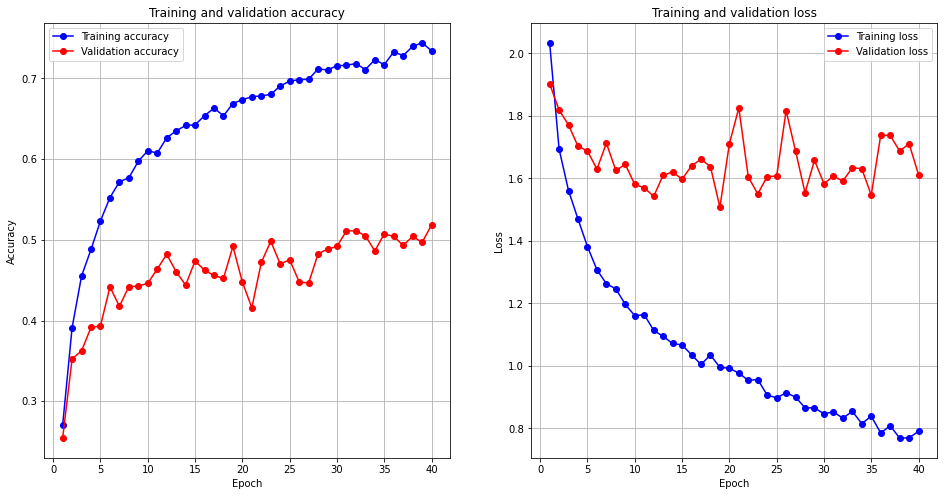

Accuracy und Loss des komplexeren CNN mit dataset 3:
Maximum accuracy:  0.674580991268158
Minimum Loss:  1.0397530794143677


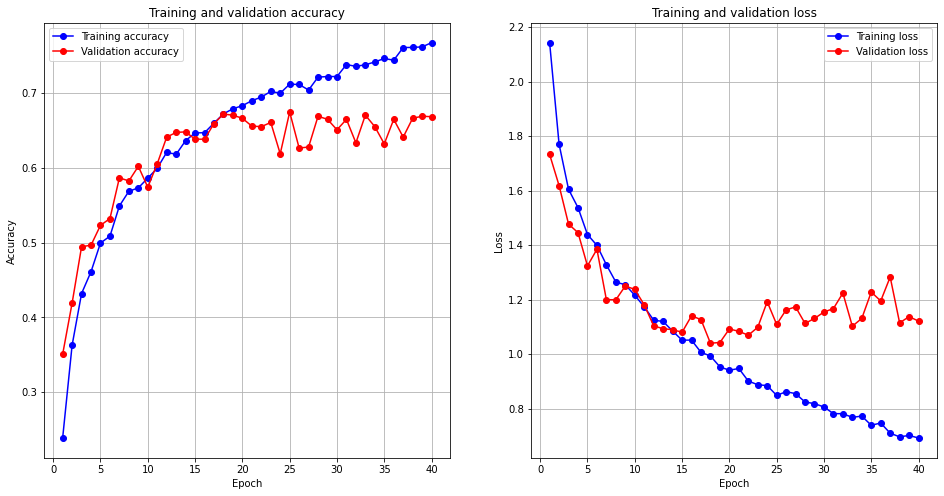

In [272]:
print("Accuracy und Loss des komplexeren CNN mit dataset 2:")
plot_accuracy(history2_1)

print("Accuracy und Loss des komplexeren CNN mit dataset 3:")
plot_accuracy(history2_2)

In [ ]:
model2_2_corL, model2_2_predL = predict_testdata(Model2_2, test_ds3)

In [ ]:
print(classification_report(model2_2_corL, model2_2_predL,target_names = class_names))

In [ ]:
plot_confusion_matrix(confusion_matrix(model2_2_corL, model2_2_predL))

### e) Model 2 - Fazit

Wir machen hier multi class classification
loss function = categorical crossentropy als standard für multi class classification, nur davon abweichen wenn es einen Grund gibt --> wir haben keinen Grund
kernel size: If your images are smaller than 128×128 you may want to consider sticking with strictly 1×1 and 3×3 filters.
strides als ersatz für max pooling? --> ausprobieren?

## 6.3 Model 3

### c) Model 3 - Introduction

Als letztes selbst erstelltes Modell soll nun mit dem zuvor erworbenen Wissen ein CNN mit noch mehr Layern und Filtern erstellt werden um zu überprüfen, ob dies die Performance weiterhin optimieren kann.

### a) Model 3 - Construction

In [278]:
def construct_cnn3(learningRate):
    cnn3 = Sequential()
    cnn3.add(RandomFlip("horizontal_and_vertical", input_shape=(64, 64,3)))
    cnn3.add(RandomRotation(0.2))
    cnn3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    cnn3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    cnn3.add(MaxPool2D((2, 2)))
    cnn3.add(Dropout(0.2))
    cnn3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    cnn3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    cnn3.add(MaxPool2D((2, 2)))
    cnn3.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
    cnn3.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
    cnn3.add(MaxPool2D((2, 2)))
    cnn3.add(Conv2D(filters=1024, kernel_size=(3, 3), activation='relu'))
    cnn3.add(Flatten())
    cnn3.add(Dense(512, activation='relu'))
    cnn3.add(Dropout(0.2))
    cnn3.add(Dense(len(class_names), activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(lr=learningRate)
    cnn3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return cnn3

**Architektur und Parameter:**  
Auf Grund der Komplexität und der längeren Trainingsdauer dieses Modells sollen hier lediglich die zuvor als gut identifizierten Parameter angwendet werden. Lediglich beim hinzufügen zusätzlicher layer wird expermintiert.

In [279]:
Model3=construct_cnn3(0.001)

In [280]:
Model3.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

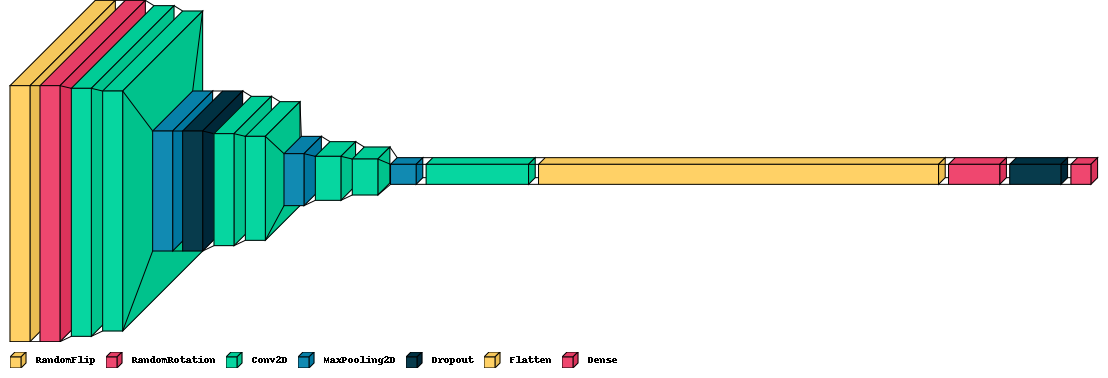

In [281]:
visualkeras.layered_view(Model3, legend=True)

In [282]:
Model3.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_34 (RandomFlip)  (None, 64, 64, 3)        0         
                                                                 
 random_rotation_31 (RandomR  (None, 64, 64, 3)        0         
 otation)                                                        
                                                                 
 conv2d_235 (Conv2D)         (None, 62, 62, 64)        1792      
                                                                 
 conv2d_236 (Conv2D)         (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_108 (MaxPooli  (None, 30, 30, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_75 (Dropout)        (None, 30, 30, 64)      

### b) Model 3 - Training

In [283]:
history3 = Model3.fit(train_ds3, batch_size=32, epochs=20, verbose=True, validation_data=val_ds3)

Epoch 1/20
212/212 [==============================] - 179s 833ms/step - loss: 2.3881 - accuracy: 0.2088 - val_loss: 2.0290 - val_accuracy: 0.1878
Epoch 2/20
212/212 [==============================] - 178s 838ms/step - loss: 1.8918 - accuracy: 0.2849 - val_loss: 1.7160 - val_accuracy: 0.3624
Epoch 3/20
212/212 [==============================] - 178s 840ms/step - loss: 1.7642 - accuracy: 0.3463 - val_loss: 1.7519 - val_accuracy: 0.3541
Epoch 4/20
212/212 [==============================] - 179s 843ms/step - loss: 1.6733 - accuracy: 0.3944 - val_loss: 1.7071 - val_accuracy: 0.3722
Epoch 5/20
212/212 [==============================] - 181s 855ms/step - loss: 1.5811 - accuracy: 0.4432 - val_loss: 1.5954 - val_accuracy: 0.4392
Epoch 6/20
212/212 [==============================] - 181s 853ms/step - loss: 1.5206 - accuracy: 0.4677 - val_loss: 1.4064 - val_accuracy: 0.5119
Epoch 7/20
212/212 [==============================] - 180s 847ms/step - loss: 1.4515 - accuracy: 0.4950 - val_loss: 1.5034 -

### a) Model 3 - Evaluation

### e) Model 3 - Fazit

## 6.4 Model 4 - Pretrained VGG16 Neural Network

### a) VGG16 - Introduction

Das Very Deep Convolutional Networks for Large-Scale Image Recognition(VGG-16) CNN ist eines der bekanntesten vortrainierten Neuronalen Netze zur Bildklassifizierung. Es wurde mit Millionen von Bildern des ImageNet Datensetz trainiert und ist in der Lage zwischen 1000 verschiedenen Output Labels zu unterscheiden.  
Nachfolgend ist die Architektur des Modell abgebildet. Diese setzt sich aus 13 Convolutional, 5 MaxPooling sowie 3 DenseLayern zusammen.

![Architektur VGG16 Modell](VGG16-architecture.PNG)  

(Bildquelle1: https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/)   

Um das Modell auf einen eigenen Datensatz anwenden zu können, werden lediglich die Convolutional und MaxPooling Layern mit ihren Gewichten verwendet. An deren Output wird eine eigene Architektur aus fully-connected layern gehängt. Wichtig ist hierbei, dass die Anzahl der Neuronen im letzten Dense Layer der Anzahl der Klassen des jeweiligen Use Cases entspricht, in unserem Projekt also 9 Neuronen für 9 verschiedene Vogelarten.


### b) VGG16 - Construction

In diesem Teil wird ein Neuronales Netz erstellt, welches die Convolutional und MaxPooling Layer des VGG16 Modells verwendet. An diese wird eine eigene Zusammensetzung aus Flatten, Dense und Dropout Layern gehängt.  
  
Im Rahmen der Modelloptimierung wurden verschiedene Kombinationen aus Dense Layern, Dropout und Pooling Layern, sowie verschiedene Werte der Hyperparameter Image_Size, Optimizer, Learning Rate, usw. getestet. Nachfolgend wird das Modell dargestellt, welches in dieser Testphase das beste Ergebnis erzielte.

Wir brauchen alle Bilder (eigene + Download) in 128 Pixel, momentan passt Datasete, wenn das nochmal geändert wird, müssen wir halt nochmal neues Datenset laden

In [ ]:
#Falls ein trainiertes Modell schon existiert, kann dies hier geladen werden. Momentan auskommentiert
#VGG16 = load_model('VGG16-128px-64dense.h5')

In [294]:
#Laden des Basis Modells mit der VGG16 Architektur
baseModelVGG16 = vgg16.VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(128, 128, 3)))

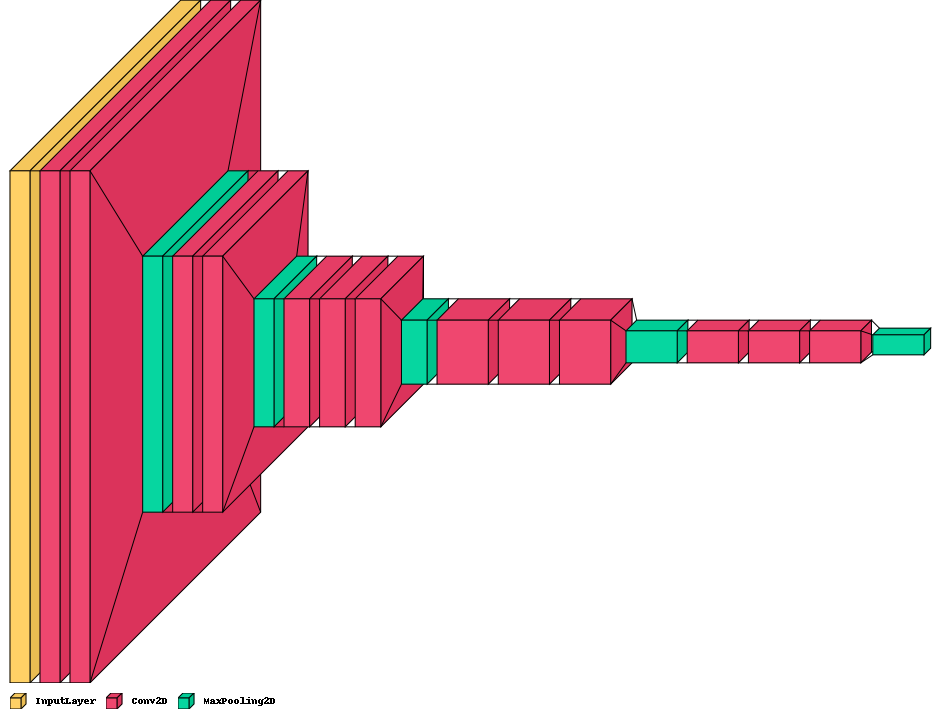

In [295]:
#Visualisierung des VGG16 Basis Modells
visualkeras.layered_view(baseModelVGG16, legend=True)

Wie bereits in der Einleitung dieses Kapitels gezeigt, ist in der obigen Abbildung zu erkennen, dass sich das VGG16 Basis Model aus 13 Convolutional Layern und 5 MaxPooling Layern zusammensetzt.  
Die Gewichte dieser Layer wurden zusammen mit der Architektur heruntergeladen. Diese werden nun auf trainable = False gestellt, sodass sich die Gewichte in der Trainingsphase des Modells nicht mehr verändern. In dieser sollen lediglich die Gewichte der selbst hinzugefügten Layern verändert werden.

In [296]:
#Gewichte in den Layern des Basis Modells einfrieren, sodass diese in der Trainingsphase nicht geupdatet werden
for layer in baseModelVGG16.layers:
    layer.trainable = False

Für das Preprocessing der Bilder bietet Keras VGG16 eine eigene Methode preprocess_input. Allerdings wurden unter Verwendung dieser Methode für train_ds und val_ds deutlich schlechtere Ergebnisse des Modells erzielt. Daher wird die Methode in diesem Notebook nicht verwendet, sondern ein eigenes Preprocessing der Bilder durchgeführt.

In [157]:
#Preprocessing Methode von VGG16, die aber nicht verwendet wird
#for batch_images, batch_labels in train_ds:
#    batch_images = vgg16.preprocess_input(batch_images, mode='tf')

Nun wird die Architektur des gesamten Modells bestimmt. Diesem wird zunächst ein Rescaling Layer hinzugefügt, welches das Intervall der einzelnen Bildpixel von [0,255] auf [0,1] reduziert. Anschließend wird das Basis Modell angehängt. Es folgen ein MaxPooling, Flatten, Dense und Dropout Layer bevor der finale Dense Layer mit 9 Output Neuronen angehängt wird.

In [297]:
#Architektur des kompletten Modells
VGG16 = Sequential()
VGG16.add(Rescaling(1.0/255, input_shape=(128, 128,3)))
VGG16.add(baseModelVGG16)
VGG16.add(MaxPool2D(pool_size=(2, 2)))
VGG16.add(Flatten())
VGG16.add(Dense(64, activation="relu"))
VGG16.add(Dropout(0.5))
VGG16.add(Dense(len(class_names), activation="softmax"))
VGG16.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 max_pooling2d_112 (MaxPooli  (None, 2, 2, 512)        0         
 ng2D)                                                           
                                                                 
 flatten_40 (Flatten)        (None, 2048)              0         
                                                                 
 dense_102 (Dense)           (None, 64)                131136    
                                                                 
 dropout_79 (Dropout)        (None, 64)                0         
                                                     

Nachfolgend ist die Architektur des gesamten Modells dargestellt, wobei das Basis Modell nur wie ein einzelner Layer erscheint. Dieser Layer beinhaltet die oben gezeigte Architektur.

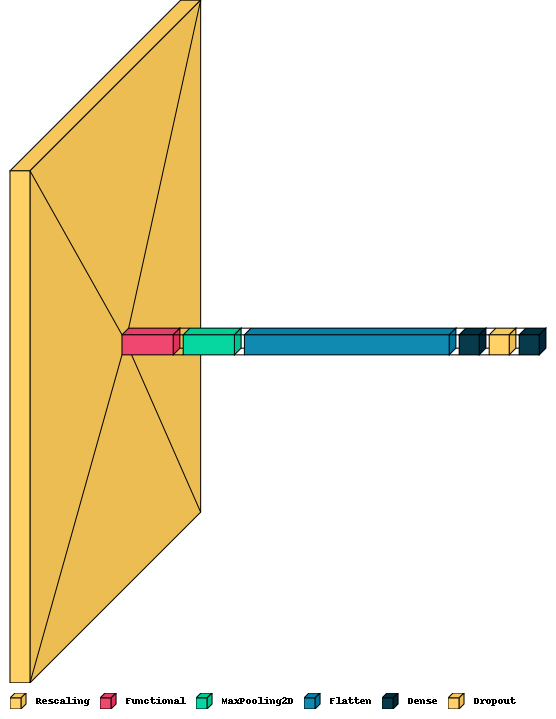

In [159]:
visualkeras.layered_view(VGG16, legend=True)

### c) VGG16 - Training

Nun folgt das Training des Modells. Dafür wird es zunächst kompiliert und anschließend unter Verwendung der .fit() Methode über 20 Epochen trainiert. Wichtig ist hierbei nochmal, dass lediglich die Gewichte der fully-connected layer trainiert werden. Die Gewichte des VGG16 BaseModels werden nicht verändert.

In [298]:
print("Compiling VGG16 Model")
optimizer = keras.optimizers.Adam(learning_rate=0.01, epsilon=0.1)
VGG16.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Compiling VGG16 Model


In [299]:
print("Fitten des vortrainierten VGG16 Netzes mit dataset 2 (in Notebook 1 erzeugte Bilder + Bilder von https://images.cv/)")
history6 = VGG16.fit(train_ds2, batch_size=batch_size2, epochs=10, verbose=True, validation_data=val_ds2)

Fitten des vortrainierten VGG16 Netzes mit dataset 2 (in Notebook 1 erzeugte Bilder + Bilder von https://images.cv/)
Epoch 1/10
318/318 [==============================] - 656s 2s/step - loss: 1.9229 - accuracy: 0.2923 - val_loss: 1.4134 - val_accuracy: 0.5782
Epoch 2/10
318/318 [==============================] - 620s 2s/step - loss: 1.5027 - accuracy: 0.4508 - val_loss: 1.1370 - val_accuracy: 0.6573
Epoch 3/10
318/318 [==============================] - 619s 2s/step - loss: 1.3853 - accuracy: 0.4991 - val_loss: 0.9714 - val_accuracy: 0.7075
Epoch 4/10
318/318 [==============================] - 624s 2s/step - loss: 1.2974 - accuracy: 0.5282 - val_loss: 1.0284 - val_accuracy: 0.6766
Epoch 5/10
318/318 [==============================] - 621s 2s/step - loss: 1.2705 - accuracy: 0.5400 - val_loss: 0.9639 - val_accuracy: 0.7236
Epoch 6/10
318/318 [==============================] - 619s 2s/step - loss: 1.2352 - accuracy: 0.5426 - val_loss: 0.8873 - val_accuracy: 0.7300
Epoch 7/10
318/318 [=====

Nach 10 Epochen hat das Modell eine Validation Accuracy von ca. 74%. Dies ist zwar noch ausbaufähig, übertrifft aber alle bisherigen Ergebnisse mit den selbst erstellten CNNs.  
Auffällig ist, dass die Training Accuracy schlecht ausfällt als die Validation Accuracy. Die Erklärung hierführ könnte in dem Dropout Layer liegen, welcher zwischen die beiden Dense Layer in den fully-connected layern geschaltet wurde. Dieser deaktiviert in der Trainingsphase 50% der Neuronen, was die Accuracy in der Trainingsphase natürlich verschlechtert. Dies soll ein Overfitting des Modells verhindern. In der Validierungsphase am Ende einer Epoche werden alle Neuronen des Neuronalen Netzes aktiviert. Somit fällt die Accuracy besser aus als in der Trainingsphase.

In [300]:
#Speichern des Modells
VGG16.save('VGG16-128px-64dense.h5')

### d) VGG16 - Evaluation

Nachfolgend wird das vortrainierte VGG16 Modell evaluiert. Hierfür beginnen wir mit der Betrachtung der Accuracy und des Losses über die Trainingsepochen.

Accuracy und Loss des vortrainierten VGG16 mit dataset d:
Maximum accuracy:  0.7401103973388672
Minimum Loss:  0.839721143245697


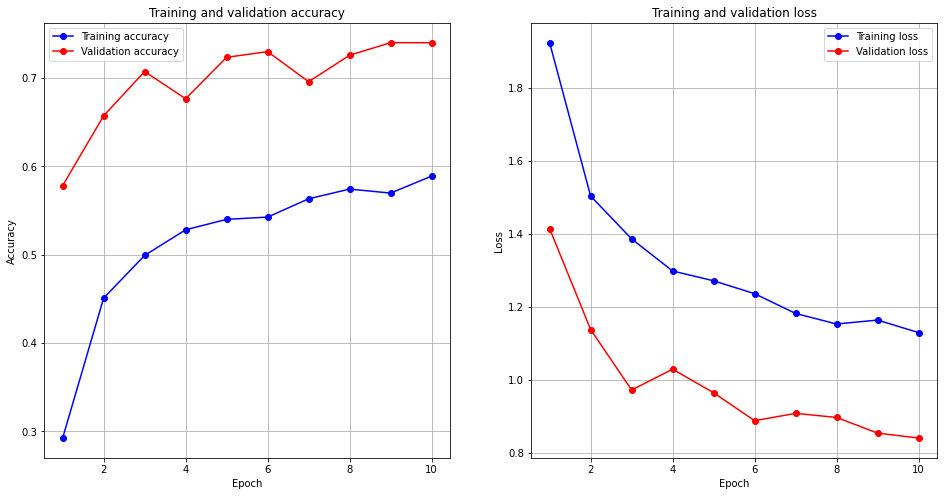

In [301]:
print("Accuracy und Loss des vortrainierten VGG16 mit dataset d:")
plot_accuracy(history6)

Wie bereits erwähnt, ist es auffällig, dass die Werte der Valdidierungsdaten für Accuracy und Loss besser sind als für die Trainingsdaten. Eine Erklärung hierfür könnte der Dropout Layer sein.  
In den ersten Epochen sind starke Verbesserungen in der Performance für beide Trainings- und Validationdaten zu erkennen. In den Validierungswerten sind danach einige Sprünge zu verzeichnen. Im Laufe der Epochen flachen alle Kurven immer mehr ab und pendeln sich nach ca. 8 Epochen langsam ein. Die Kurven lassen darauf schließen, dass weitere Epochen noch leichte Verbesserungen bewirken würden, eine starke Verbesserung ists aber nicht mehr anzunehmen. Daher wurde aus Laufzeitgründen auf weiteres Training verzichtet.

Im Anschluss werden die Testdaten mit dem VGG16 Modell klassifiziert.

In [302]:
VGG16_corL, VGG16_predL = predict_testdata(VGG16, test_ds2)

1/1 [==============================] - 1s 1s/step


In [303]:
print(classification_report(VGG16_corL, VGG16_predL, target_names=class_names))

              precision    recall  f1-score   support

     chicken       0.59      0.48      0.53       180
    cockatoo       0.50      0.77      0.60       161
       eagle       0.73      0.64      0.68       241
    flamingo       0.86      0.80      0.83       297
     ostrich       0.88      0.75      0.81       252
         owl       0.85      0.70      0.77       253
     penguin       0.68      0.80      0.73       208
         tit       0.74      0.85      0.79       286
       tucan       0.81      0.80      0.80       298

    accuracy                           0.74      2176
   macro avg       0.74      0.73      0.73      2176
weighted avg       0.76      0.74      0.74      2176



Der Classification Report zeigt die Werte der Testdaten aufgeteilt nach den verschiedenen Labeln.  
Auffällig ist, dass die ersten drei Klassen Chicken, Cockatoo und Eagle die schlechteste Performance (Precision, Recall und F1-Score) haben. Dies ist darin zu begründen, dass in dem verwendeten Datenset 2 von diesen 3 Klassen die wenigsten Bilder vorhanden sind (siehe Kapitel zu Dataset 2). Um die Werte in den 3 Klassen zu verbessern, sind somit zusätzliche Bilder von Chicken, Cockatoo und Eagle notwendig. Diese können entweder von weiteren Quellen heruntergerladen werden oder künstlich durch Image Augmentation erzeugt werden. Die im Kapitel zu Image Augmentation gezeigten Techniken müssten hierfür für diese Klassen angewendet und die Ergebnisse physisch gespeichert und dem Datenset hinzugefügt werden.  
Die Klasse Ostrich hat den besten Wert in Precision, die KLasse Tit für Recall und die Klasse Flamingo für F1-Score.  
Da für unseren Use Case weder Precicion noch Recall als wichtigere als die andere Metrik erachtet werden können, schneidet als im arithmetischen Mittelwert der beiden Werte (F1-Score) die Klasse Flamingo am besten ab und wird somit als die beste vom Modell vorhergesagte Klasse deklariert.

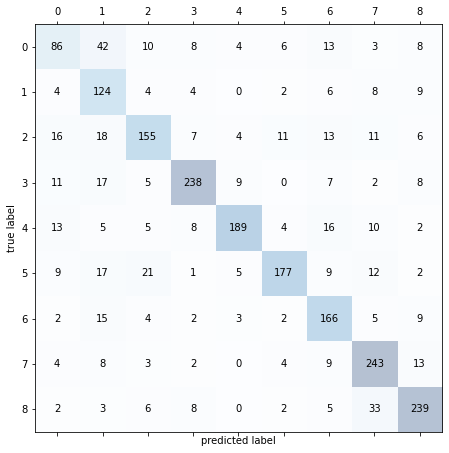

In [304]:
plot_confusion_matrix(confusion_matrix(VGG16_corL, VGG16_predL))

In der Confusion Matrix ist zu erkennen, dass grundsätzlich die meisten Bilder vom Modell korrekt klassifiziert wurden (diagonale Linie durch die Matrix zeigt hohe Werte). In den ersten 3 Klassen (Chciken, Cockatoo und Ealge) wurden im Vergleich zu den anderen Klassen mehr Bilder nicht korrekt klassifiziert, indem Bilder dieser Klassen entweder als eine andere Klasse gelabelt oder andere Klassen fälschlicherweise als eine dieser 3 Klassen klassifiziert wurden. Auffällig ist hier beispielsweise, dass 42 Chicken Bilder als Cockatoo gelabeld wurden. Wie bereits erwähnt, liegen für diese 3 Klassen die wenigsten Bilder vor. Um die Performance zu verbessern, bedarf es weitere Bilder dieser Klassen.  
Ansonsten sind die Werte breit gestreut und es ist nicht zu erkennen, dass beispielsweise zwei Klassen durch das Modell häufig miteinander verwechselt wurden.

Nachfolgend betrachten wir die 64 Feature Maps des ersten Hidden Layer im VGG116 Modell.

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

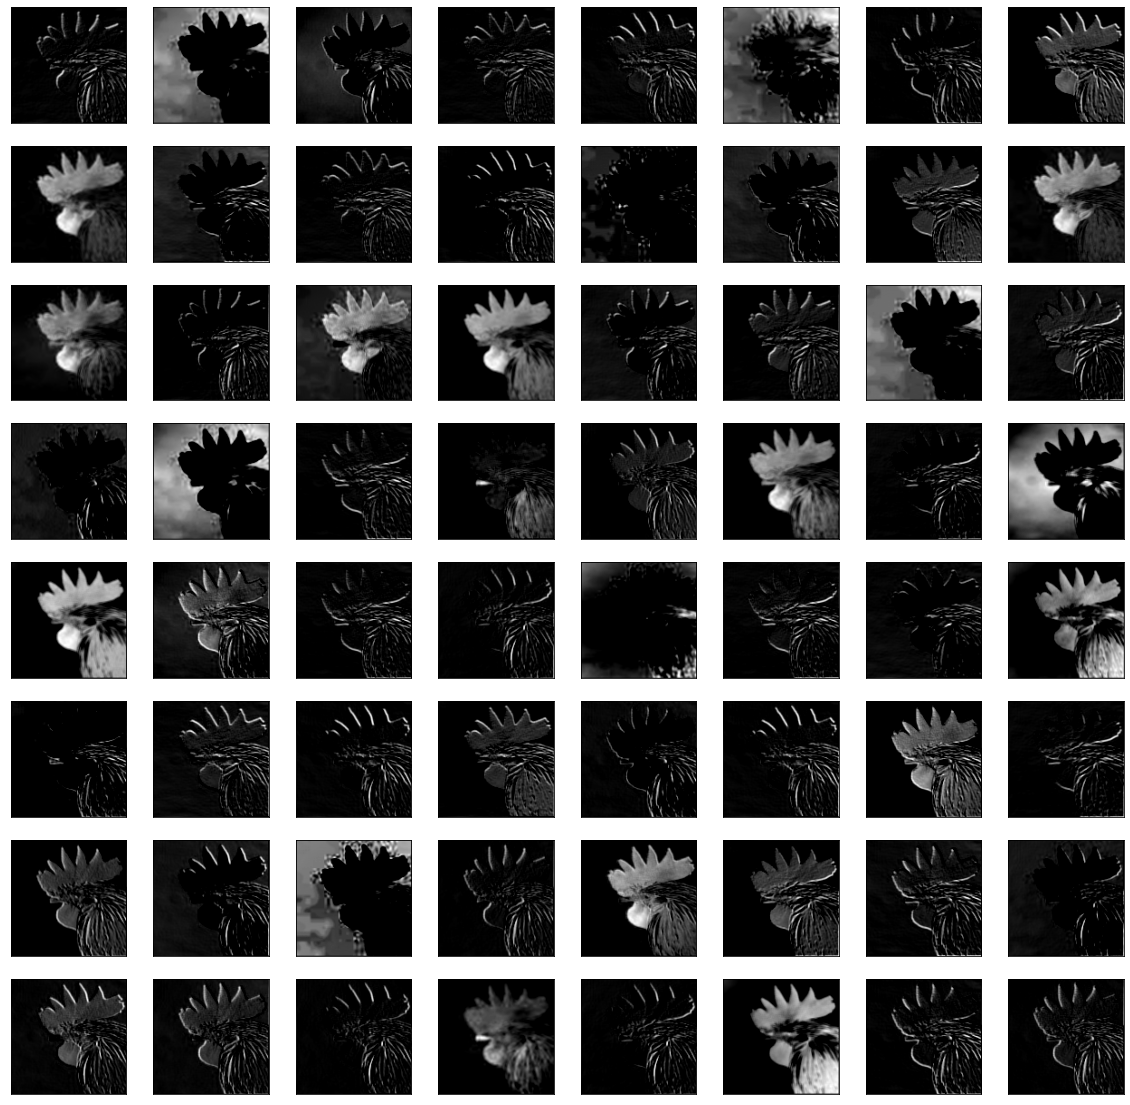

In [306]:
# definiere modell als output nach ersten hidden layer
model = Model(inputs=baseModelVGG16.inputs, outputs=baseModelVGG16.layers[1].output)
baseModelVGG16.summary()
# Bild mit richtiger Image Size laden
img = load_img(r"C:\Users\olive\Documents\HdM\3. Semester\Machine Learning\Project Whale\Bilder2\chicken\0K3D5SDTO0RJ.jpg", target_size=(128, 128))
# Bild zu Array konvertieren
img = img_to_array(img)
# Dimension expandieren
img = expand_dims(img, axis=0)
# Peprocess Bild für VGG16
img = vgg16.preprocess_input(img)
# erzeugen der Feature Maps für ausgewählten Layer
feature_maps = model.predict(img)
# alle Feature Maps plotten
square = 8
ix = 1
plt.figure(figsize=(20,20))
for _ in range(square):
	for _ in range(square):
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
pyplot.show()

### e) VGG16 - Fazit

Das vortrainierte VGG16 Modell mit eigenen fully-connected layern zeigt bisher das beste Ergebnis.  
Zudem wurden in der Evaluation noch weitere Optimierungspotenziale durch das Hinfügen weiterer Bilder der Klassen 1-3 sowie dem Trainieren zusätzlicher Epochen erkannt. Dadurch ist anzunehmen, dass sich die Performance in allen Metriken (Gesamt-Accuracy sowie Precision, Recall und F1-Score der einzelnen Klassen) noch weiter verbessern.  
Dieses Modell sollte somit in die finale Auswahl aufgenommen werden.

## 6.5 Model 5 - Pretrained Xception Neural Network

### a) Xception - Introduction

Das Xception Modell ist eine Weiterentwicklung des Inception Modells. Wie das VGG16 Modell wurde auch dieses mit dem ImageNet Datenset trainiert und kann zwischen 1000 Klassen unterscheiden. Dieses Modell hat eine Tiefe von 71 Layern, ist also nochmal deutlich tiefer als das VGG16 Modell.  
Die Architektur ist nachfolgend dargestellt:

![Architektur Xception Modell](Xception-architecture.PNG)  

(Bildquelle2: https://medium.com/analytics-vidhya/image-recognition-using-pre-trained-xception-model-in-5-steps-96ac858f4206)

Auch bei diesem Pretrained Modell wird nur das Basismodell mit seinen Gewichten verwendet und an dessen Output eine eigene Architektur aus fully-connected layern angehängt.

### b) Xception - Construction

Wie bereits beim VGG116 Modell wird auch hier nur die Basis Architektur des Xception Modells mit seinen Gewichten geladen und an diese mit einer eigenen Architektur von fully-connected layern kombiniert.  

Auch hier wurden verschiedene Architekturen von fully-connected layern, sowie der Hyperparameter getestet. Es wird nachfolgend nur die Kombination gezeigt, welche hierbei das beste Ergebnis erzielte.

In [ ]:
#Xcept = load_model('Xcept-256px-128-256dense.h5')

Das Xcpetion Modell wurde ursprünglich mit einer Bildgröße von 299x299 Pixeln trainiert. Daher wird für dieses Modell eine größere Image_Size als in den vorherigen Modellen verwendet. Dafür muss zunächst das dataset 4 mit einer Image_Size von 256x256 Pixeln erstellt werden.

In [284]:
image_size4=[256, 256]
batch_size4=128
train_ds4, val_ds4 = create_datasets(image_size4, batch_size4, r"C:\Users\olive\Documents\HdM\3. Semester\Machine Learning\Project Whale\Bilder2")
test_ds4 = val_ds4.take(25)
val_ds4 = val_ds4.skip(25)

Found 14500 files belonging to 9 classes.
Using 10150 files for training.
Found 14500 files belonging to 9 classes.
Using 4350 files for validation.


Anschließend wird die Basisarchitektur des Xception Modells mit seinen Gewichten geladen und diese visualisiert.

In [285]:
baseModelXception= xception.Xception(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')

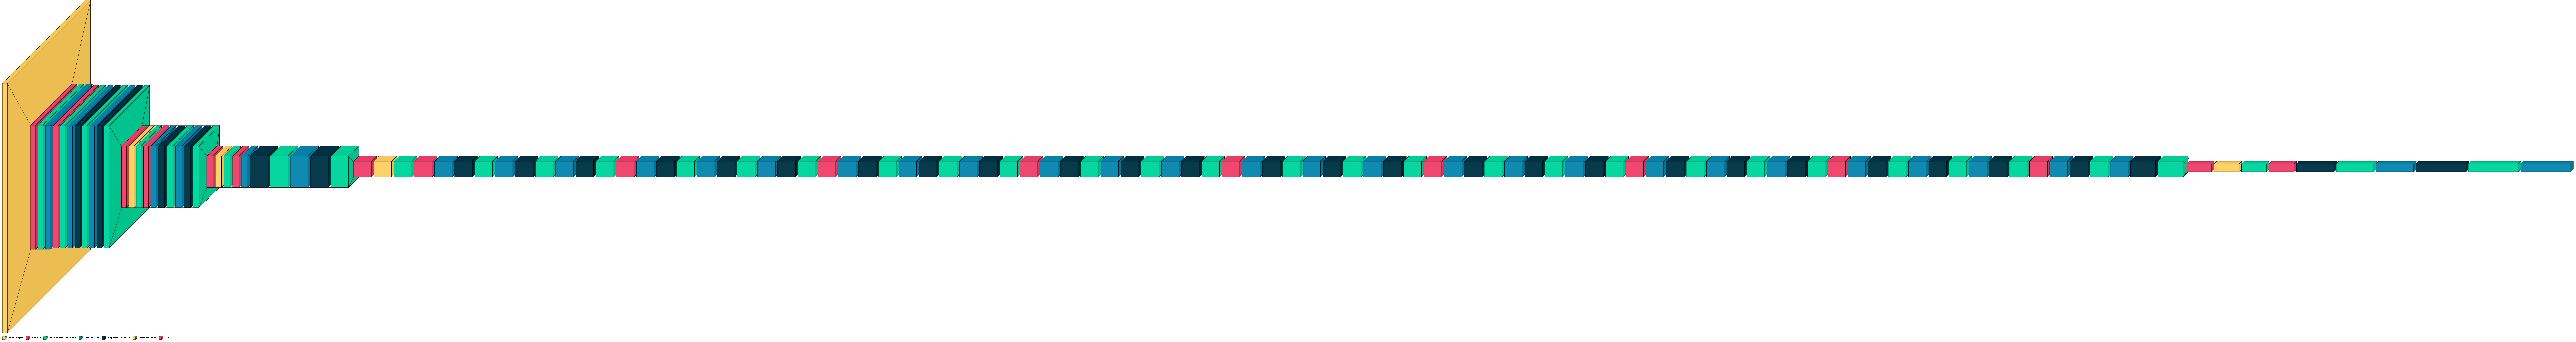

In [286]:
visualkeras.layered_view(baseModelXception, legend=True)

Es wird deutlich, dass das Xception Modell eine deutlich komplexere Architektur als alle zuvor erstellten Modelle besitzt. Es wechseln sich eine Vielzahl verschiedener Dense, Pooling, Activation und Batch Layer ab.  
Die Gewichte dieser Layer werden auch hier auf Trainable = False gestellt, sodass sie sich in der Trainingsphase nicht mehr verändern.

In [287]:
#Gewichte in den Layern des Basis Modells einfrieren, sodass diese in der Trainingsphase nicht geupdatet werden
for layer in baseModelXception.layers:
    layer.trainable = False

Zwar bietet auch dieses Modell eine eigene Preproessing Methode, allerdings wurden auch hier schlechtere Ergebnisse erzielt, als wenn ein eigenes Preprocessing durchgeführt wird. Daher wird die Methode preprocess_input nicht verwendet.

In [174]:
##for batch_images, batch_labels in train_ds:
 #   batch_images = xception.preprocess_input(batch_images)

Da das Xception Modell ein Intervall der Bildpixel von [-1,1] erwartet, wird ein zunächst ein entsprechendes Rescaling durchgeführt und der Output and das Basis Modell übergeben. Anschließend folgen verschiedene fully-connected layers.

In [288]:
Xcept = Sequential()
Xcept.add(Rescaling(scale=1./127.5, offset=-1., input_shape=(256, 256 ,3))) #Xception Model erwartet Pixelinter von [-1,1]
Xcept.add(baseModelXception)
Xcept.add(MaxPool2D(pool_size=(2, 2)))
Xcept.add(Flatten())
Xcept.add(Dense(128, activation="relu"))
Xcept.add(Dropout(0.2))
Xcept.add(Dense(256, activation="relu"))
Xcept.add(Dropout(0.5))
Xcept.add(Dense(len(class_names), activation="softmax"))
Xcept.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 max_pooling2d_111 (MaxPooli  (None, 4, 4, 2048)       0         
 ng2D)                                                           
                                                                 
 flatten_39 (Flatten)        (None, 32768)             0         
                                                                 
 dense_99 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_77 (Dropout)        (None, 128)               0         
                                                     

### c) Xception - Training

In [289]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, epsilon=0.1)
Xcept.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [290]:
print("Fitten des vortrainierten Xception Netz mit Dataset 4")
history7 = Xcept.fit(train_ds4, batch_size=batch_size4, epochs=10, verbose=True, validation_data=val_ds4)

Fitten des vortrainierten Xception Netz mit Dataset 4
Epoch 1/10
80/80 [==============================] - 975s 12s/step - loss: 1.5072 - accuracy: 0.5030 - val_loss: 0.5257 - val_accuracy: 0.9026
Epoch 2/10
80/80 [==============================] - 1107s 14s/step - loss: 0.5780 - accuracy: 0.8343 - val_loss: 0.2672 - val_accuracy: 0.9322
Epoch 3/10
80/80 [==============================] - 1142s 14s/step - loss: 0.3735 - accuracy: 0.8949 - val_loss: 0.2163 - val_accuracy: 0.9348
Epoch 4/10
80/80 [==============================] - 1180s 15s/step - loss: 0.2944 - accuracy: 0.9164 - val_loss: 0.1940 - val_accuracy: 0.9452
Epoch 5/10
80/80 [==============================] - 1191s 15s/step - loss: 0.2486 - accuracy: 0.9260 - val_loss: 0.1683 - val_accuracy: 0.9487
Epoch 6/10
80/80 [==============================] - 1207s 15s/step - loss: 0.2145 - accuracy: 0.9395 - val_loss: 0.1720 - val_accuracy: 0.9522
Epoch 7/10
80/80 [==============================] - 1210s 15s/step - loss: 0.1927 - accur

Nach 10 Trainingsepochen liegen Trainings- und Validationaccuracy beide bei ca. 95%.  

In [307]:
Xcept.save('Xcept-256px-128-256dense.h5')

### d) Xception - Evaluation

Für die Evaluation des Modells werden zunächst der Verlauf von Accuracy und Loss über die Epochen betrachtet.

Accuracy und Loss des vortrainierten Xception mit dataset 4 (alle Bilder und 256 Pixel):
Maximum accuracy:  0.9591304063796997
Minimum Loss:  0.15086688101291656


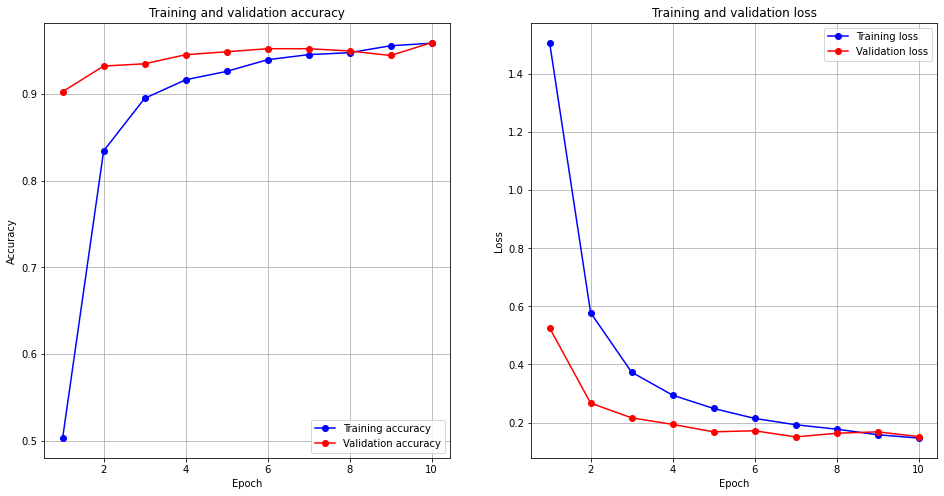

In [308]:
print("Accuracy und Loss des vortrainierten Xception mit dataset 4 (alle Bilder und 256 Pixel):")
plot_accuracy(history7)

In den Plots ist wieder eine starke Verbesserung von Accuracy und Loss in den ersten 3 Epochen zu erkennen. Mit der 4. Epoche werden die Verbesserungen kleiner.  
Auffällig ist, dass die Validation Accuracy und der Loss zunächst deutlich besser als die der Trainingsdaten sind. Dies könnte wie beim VGG16 Modell an den Dropout Layern liegen. In diesem Modell verringert sich dieser Unterschied im Laufe der Epochen deutlich und ist nach 8 Epochen kaum noch vorhanden. Nach 9 Epochen sind Accuracy und Loss der Trainingsdaten siginifikant geringer als die der Validierungsdaten.  
Es ist anzunehmen, dass das Trainieren weitere Epochen keine deutliche Verbesserung mehr bringen würde.

Nun werden die Testdaten durch das Modell klasifiziert und anschließend die Classification Metrics und die Confusion Matrix für diese ausgegeben.

In [309]:
Xcept_corL, Xcept_predL = predict_testdata(Xcept, test_ds4)

4/4 [==============================] - 13s 3s/step


In [310]:
print(classification_report(Xcept_corL, Xcept_predL, target_names=class_names))

              precision    recall  f1-score   support

     chicken       0.92      0.92      0.92       257
    cockatoo       0.95      0.93      0.94       238
       eagle       0.92      0.94      0.93       359
    flamingo       0.95      0.96      0.96       409
     ostrich       0.98      0.98      0.98       387
         owl       0.90      0.92      0.91       370
     penguin       0.96      0.97      0.96       288
         tit       0.98      0.97      0.97       459
       tucan       0.99      0.96      0.97       433

    accuracy                           0.95      3200
   macro avg       0.95      0.95      0.95      3200
weighted avg       0.95      0.95      0.95      3200



Für dieses Modell liegen alle Performance Metriken (Precision, Recall und F1-Score) über 90% und schneiden somit sehr gut ab.  
Die schlechtesten Werte verzeichnet die Klasse Owl. Auch für diese Klasse liegen vergleichsweise eher weniger Bilder vor. (siehe Kapitel zu dataset 2, hier wird zwar dataset 4 verwendet, dieses ist inhaltlich aber das dataset 2 nur mit anderen Pixelwerten). Dies kann aber nicht der einzige Grund sein, da für die Klassen 1-3 noch weniger Bilder vorhanden sind. Allerdings schneiden auch diese drei Klassen schlechter ab als die anderen. Klasse Penguin enthält ebenfalls weniger Bilder als Klasse Owl, schneidet aber trotzdem deutlich besser ab. Dass Owl trotzdem schlechter abschneidet, könnte in einer höheren Intraclass Differenz in Klasse Owl bzw. in einer geringeren Intraclass Differenz der Penguin begründet sein. Klasse Penguin weißt zudem sehr deutliche Merkmale auf (immer schwarz, weiße Vögel), weshalb diese Klasse womöglich auch mit verhältnismäßig wenig Bilder gut für das Modell erkennbar ist.
Die Gesamtperformance des Modells lässt sich daher vermutlich noch durch das Hinzufügen weiterer Bilder dieser Klassen verbessern.  
Den besten F1-Score hat die Klasse Ostrich, bei der Precision und Recall bei den gleichhohen Wert von 98% erzielen. 

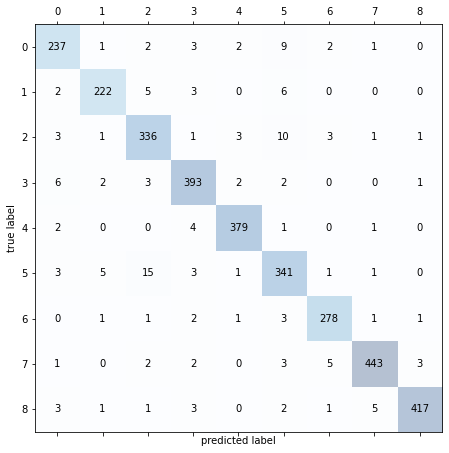

In [311]:
plot_confusion_matrix(confusion_matrix(Xcept_corL, Xcept_predL))

Passend zu den Classification Metrics zeigt auch die Confusion Matrix überwiegend korrekt vorhergesagte Werte.  
Die Klassen 1-3 sowie 5 beinhalten mehr FP und FN. Heraus sticht hierbei, dass die Klassen Owl 2 (Eagle) und 5 (Owl) häufig verwechselt werden, da 15 Eulenbilder als Adler und 10 Adlerbilder als Eule klassifiziert wurden.  


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 32, 32, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 32, 32, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 16, 16, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 16, 16, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_19 (Add)                   (None, 16, 16, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_18[0][0]']                 
                                                                                                  
 block10_sepconv1_act (Activati  (None, 16, 16, 728)  0          ['add_19[0][0]']                 
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 16, 16, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 16, 16, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 16, 16, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 16, 16, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_22 (A

IndexError: index 32 is out of bounds for axis 3 with size 32

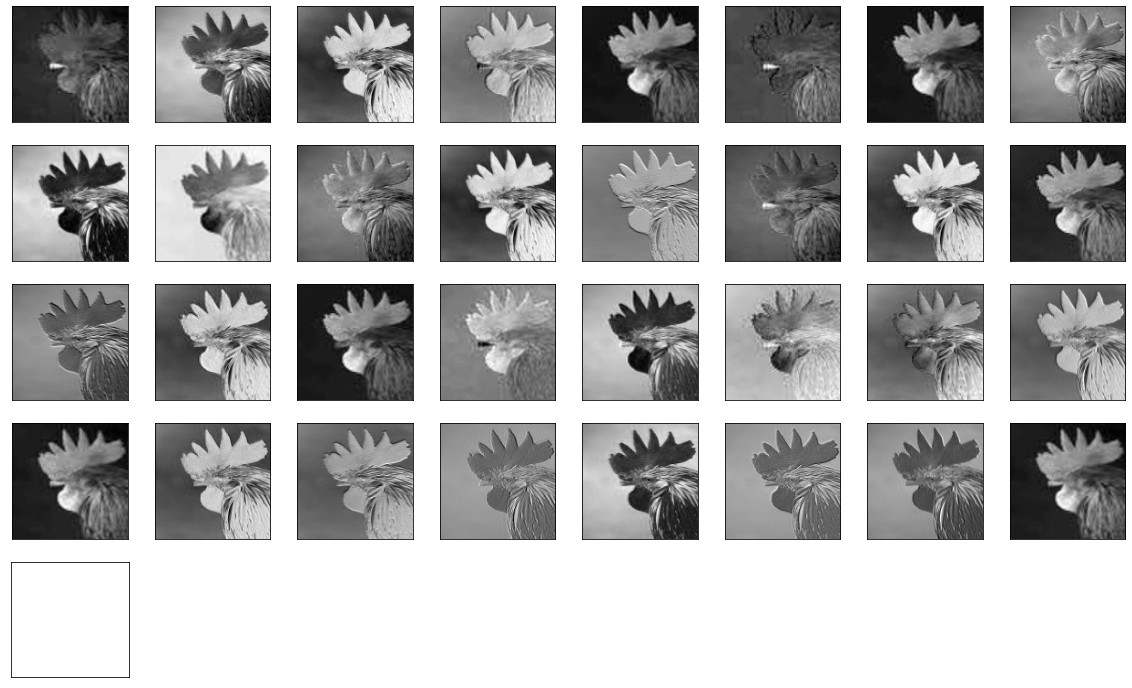

In [313]:
# plot feature map of first conv layer for given image

# redefine model to output right after the first hidden layer
model = Model(inputs=baseModelXception.inputs, outputs=baseModelXception.layers[1].output)
baseModelXception.summary()
# load the image with the required shape
img = load_img(r"C:\Users\olive\Documents\HdM\3. Semester\Machine Learning\Project Whale\Bilder2\chicken\0K3D5SDTO0RJ.jpg", target_size=(256, 256))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = vgg16.preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
plt.figure(figsize=(20,20))
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = pyplot.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
pyplot.show()

### e) Xception - Fazit

# 7. Evaluation of best model

# 8. Projekt Fazit

# 9. Quellen

zusätzliche Bilder: https://images.cv/  
Bildquelle 1: https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/  
Bildquelle 2: https://medium.com/analytics-vidhya/image-recognition-using-pre-trained-xception-model-in-5-steps-96ac858f4206